<h1>1.Variable Selection and Data Cleaning

- you just need to run this for one time!

In [ ]:
# !pip install --upgrade tensorflow
# !pip install keras -U --pre
# !pip install -U -q PyDrive
# !pip install -U windrose
# !pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import tqdm
import re
from string import punctuation
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import keras.backend as K
import tensorflow as tf

%matplotlib inline

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
from statsmodels.formula.api import ols
import warnings
warnings.simplefilter("ignore")

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

Using TensorFlow backend.


In [2]:
NFL = pd.read_csv('train.csv',low_memory='False')
NFL.drop_duplicates(inplace=True)
NFL

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509760,2018123015,20181230154157,home,84.57,24.37,4.36,1.79,0.47,148.08,183.34,...,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE


<h2>Player Ability : BMI Classification

In [3]:
NflIds=NFL.NflId.unique()
HeightTemp = NFL.PlayerHeight.str.split('-')
Height=[int(h[0])*12+int(h[1]) for h in HeightTemp]
NFL.PlayerHeight=Height

In [4]:
Heights=[]
Weights=[]
BMI=[]
for fid in NflIds:
    Heights.append(NFL[NFL['NflId']==fid].iloc[0][['NflId','PlayerHeight']])
    Weights.append(NFL[NFL['NflId']==fid].iloc[0][['NflId','PlayerWeight']])
    BMI.append(NFL[NFL['NflId']==fid].iloc[0][['NflId','PlayerHeight','PlayerWeight']])
Heights=pd.DataFrame(Heights)
Weights=pd.DataFrame(Weights)
BMI=pd.DataFrame(BMI)
BMI=BMI.assign(BMI=703*BMI.PlayerWeight/BMI.PlayerHeight**2)
def BMIClassify(df,ind,col):
    if df.loc[ind,col]<28:
        return 'Group 1'
    elif df.loc[ind,col]>35:
        return 'Group 3'
    else:
        return 'Group 2'

#for all players
NFLPlayers=[]
for fid in NflIds:
    NFLPlayers.append(NFL[NFL['NflId']==fid].iloc[0])
NFLPlayers=pd.DataFrame(NFLPlayers)

S_mean=NFLPlayers.groupby('NflId')['S'].mean()
BMI.set_index('NflId',inplace=True)
BMI['S_mean']=S_mean
groupedS=BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))

A_mean=NFLPlayers.groupby('NflId')['A'].mean() 
BMI['A_mean']=A_mean
groupedA=BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))

#for rushers only
NFLRushers=NFL[NFL['NflIdRusher']==NFL['NflId']]

S_mean_R = NFLRushers.groupby('NflIdRusher')['S'].mean()
BMI['S_mean_R'] = S_mean_R
groupedS = BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))

A_mean_R = NFLRushers.groupby('NflIdRusher')['A'].mean()
BMI['A_mean_R'] = A_mean_R
groupedA = BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))

#BMI dataframe with position column
BMI1=NFLRushers.merge(BMI,how='left',on='NflId')
groupedM = BMI1.groupby(lambda x: BMIClassify(BMI1,x,'BMI'))
#groupedM.get_group('Group 3')['Position'].value_counts()

NFL['PlayerBMI'] = 703*(NFL['PlayerWeight']/(NFL['PlayerHeight'])**2)

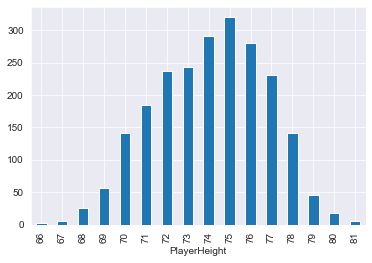

In [5]:
Heights.groupby("PlayerHeight").size().plot(kind='bar')

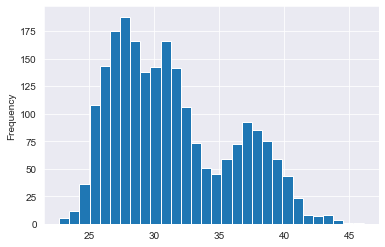

In [6]:
BMI.BMI.plot(kind='hist',bins=30)
# 3 groups
# BMI<30
# 30<BMI<35
# BMI>35

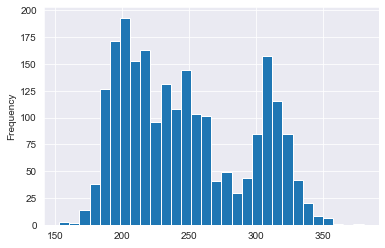

In [7]:
Weights.iloc[:,1].plot(kind='hist',bins=30)

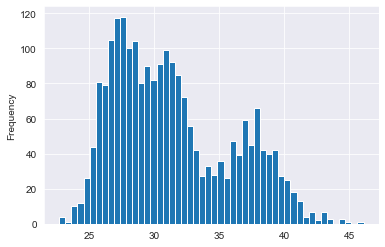

In [8]:
BMI.BMI.plot(kind='hist',bins=50)

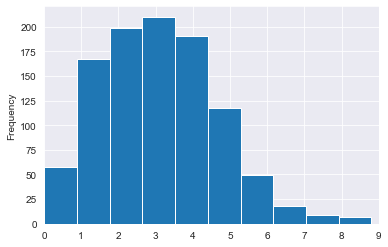

In [9]:
BMI[BMI.BMI<30].S_mean.plot(kind='hist',bins=10,xlim=[0,9])

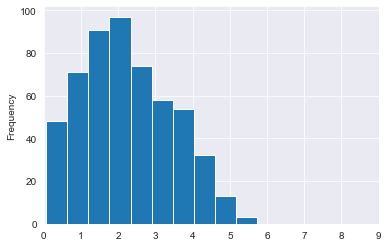

In [10]:
BMI[BMI.BMI>35].S_mean.plot(kind='hist',bins=10,xlim=[0,9])

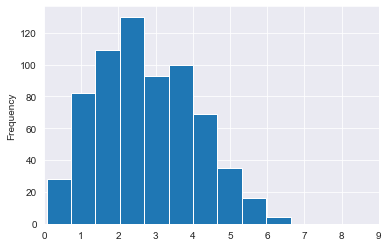

In [11]:
BMI[(BMI.BMI>=30)&(BMI.BMI<=35)].S_mean.plot(kind='hist',bins=10,xlim=[0,9])

In [12]:
def BMIClassify(df,ind,col):
    if df.loc[ind,col]<30:
        return 'Group 1'
    elif df.loc[ind,col]>35:
        return 'Group 3'
    else:
        return 'Group 2'
groupedS=BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))

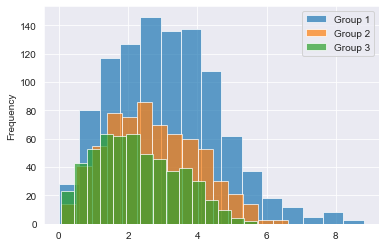

In [13]:
for i in range(1,4):
    groupedS.get_group('Group '+str(i))['S_mean'].plot(kind='hist',label='Group '+ str(i),bins=15,alpha=0.7)
plt.legend()
plt.show()

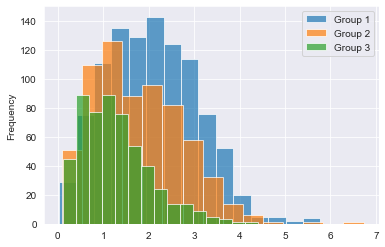

In [14]:
A_mean=NFLPlayers.groupby('NflId')['A'].mean()
BMI['A_mean']=A_mean
groupedA=BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))
for i in range(1,4):
    groupedA.get_group('Group '+str(i))['A_mean'].plot(kind='hist',label='Group '+ str(i),bins=15,alpha=0.7)
plt.legend()
plt.show()

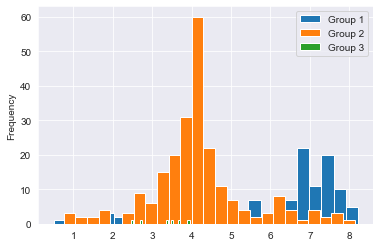

In [15]:
S_mean_R = NFLRushers.groupby('NflIdRusher')['S'].mean()
BMI['S_mean_R'] = S_mean_R
def BMIClassify(df,ind,col):
    if df.loc[ind,col]<28:
        return 'Group 1'
    elif df.loc[ind,col]>35:
        return 'Group 3'
    else:
        return 'Group 2'
groupedS = BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))
for i in range(1,4):
    groupedS.get_group('Group '+str(i))['S_mean_R'].plot(kind='hist',label='Group '+ str(i),bins=25)
plt.legend()
plt.show()

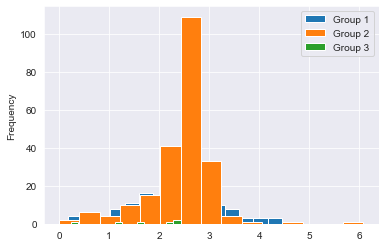

In [16]:
A_mean_R = NFLRushers.groupby('NflIdRusher')['A'].mean()
BMI['A_mean_R'] = A_mean_R
groupedA = BMI.groupby(lambda x: BMIClassify(BMI,x,'BMI'))
for i in range(1,4):
    groupedA.get_group('Group '+str(i))['A_mean_R'].plot(kind='hist',label='Group '+ str(i),bins=15)
plt.legend()
plt.show()

## Player Ability : Age

In [17]:
#time handoff and snap and player birthdate
NFL['TimeHandoff'] = NFL['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
NFL['TimeSnap'] = NFL['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
NFL['TimeDelta'] = NFL.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
NFL['PlayerBirthDate'] = NFL['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
#Let's use the time handoff to calculate the players age
seconds_in_year = 60*60*24*365.25
NFL['PlayerAge'] = NFL.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
NFL = NFL.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)

<h2>Player Ability : Rusher Ranking

In [18]:
# 2017 Player Ranking data
for index in range(1,8):
    url1 = 'http://www.nfl.com/stats/categorystats?tabSeq=0&season=2017&seasonType=REG&experience=&Submit=Go&archive=true&statisticCategory=RUSHING&conference=null&d-447263-p='
    url2 = str(index)+'&qualified=true'
    url=url1+url2
    import requests
    import lxml.html as lh
    import pandas as pd
    response = requests.get(url)
    doc = lh.fromstring(response.content)
    tr_elements = doc.xpath('//tr')
    col=[]
    i=0
    for t in tr_elements[0]:
        i+=1
        name=t.text_content()
        col.append((name,[]))
    for j in range(1,len(tr_elements)):
        T=tr_elements[j]
        i=0
        for t in T.iterchildren():
            data=t.text_content()
            col[i][1].append(data)
            i+=1
    Dict={title:column for (title,column) in col}
    df=pd.DataFrame(Dict)
    df=df.replace('\n','',regex=True)
    df=df.replace('\t','',regex=True)
    df.columns=df.columns.str.replace('\n','')
    if index==1:
        df_new=df.copy()
    else:
        df_new=pd.concat([df_new,df],ignore_index=True)
df_new.to_csv('2017_NflPlayers_RushingPerformance.csv')

# 2018 player ranking data 
for index in range(1,8):
    url1 = 'http://www.nfl.com/stats/categorystats?tabSeq=0&season=2018&seasonType=REG&experience=&Submit=Go&archive=true&d-447263-p='
    url2 = str(index)+'&statisticCategory=RUSHING&conference=null&qualified=true'
    url=url1+url2
    import requests
    import lxml.html as lh
    import pandas as pd
    response = requests.get(url)
    doc = lh.fromstring(response.content)
    tr_elements = doc.xpath('//tr')
    col=[]
    i=0
    for t in tr_elements[0]:
        i+=1
        name=t.text_content()
        col.append((name,[]))
    for j in range(1,len(tr_elements)):
        T=tr_elements[j]
        i=0
        for t in T.iterchildren():
            data=t.text_content()
            col[i][1].append(data)
            i+=1
    Dict={title:column for (title,column) in col}
    df=pd.DataFrame(Dict)
    df=df.replace('\n','',regex=True)
    df=df.replace('\t','',regex=True)
    df.columns=df.columns.str.replace('\n','')
    if index==1:
        df_new=df.copy()
    else:
        df_new=pd.concat([df_new,df],ignore_index=True)
df_new.to_csv('2018_NflPlayers_RushingPerformance.csv')

In [19]:
#rusher_ranking
# We need to find all rusher player's I want
# The threshold is 1100.
def get_rusher():
    for i in NFL.NflIdRusher.unique().tolist():
        return NFL.groupby(['NflIdRusher']).count()['PlayId']>=1100

rusher=get_rusher()
id_list=rusher[rusher.values==True].index.tolist()
id_list

player_ranking_2017 = "2017_NflPlayers_RushingPerformance.csv"
player_2017 = pd.read_csv(player_ranking_2017)
df2017 = NFL[(NFL['Season']==2017)&(NFL['NflId']==NFL['NflIdRusher'])]

ranking_2017= player_2017.set_index('Player').T.to_dict('list')
df2017_dict = df2017.set_index('DisplayName').T.to_dict('list')

rusher_2017 = df2017['DisplayName'].unique()
rusher_dict_2017=dict()
for i in range(len(rusher_2017)):
    if rusher_2017[i] in ranking_2017.keys() and df2017_dict[rusher_2017[i]][10] in id_list:
        rusher_dict_2017[rusher_2017[i]] = [ranking_2017[rusher_2017[i]][1],df2017_dict[rusher_2017[i]][10],2017]
#2018
player_ranking_2018 = "2018_NflPlayers_RushingPerformance.csv"
player_2018 = pd.read_csv(player_ranking_2018)
df2018 = NFL[(NFL['Season']==2018)&(NFL['NflId']==NFL['NflIdRusher'])]

ranking_2018= player_2018.set_index('Player').T.to_dict('list')
df2018_dict = df2018.set_index('DisplayName').T.to_dict('list')

rusher_2018 = df2018['DisplayName'].unique()
rusher_dict_2018=dict()
for i in range(len(rusher_2018)):
    if rusher_2018[i] in ranking_2018.keys() and df2018_dict[rusher_2018[i]][10] in id_list:
        rusher_dict_2018[rusher_2018[i]] = [ranking_2018[rusher_2018[i]][1],df2018_dict[rusher_2018[i]][10],2018]

#2018 year rusher ranking dataframe
s = pd.Series(rusher_dict_2018, name='details')
a=pd.DataFrame()
for i in range(len(s)):
    a.loc[i,'DisplayName2018']=s.index[i]
    a.loc[i,'RusherRanking2018']=s[i][0]
    a.loc[i,'NflIdRusher']=s[i][1]
a.NflIdRusher=a.NflIdRusher.astype('int64')
a.RusherRanking2018=a.RusherRanking2018.astype('int64')
a=a.set_index("NflIdRusher", drop=True, append=False, inplace=False, verify_integrity=False)

#2018 year rusher ranking dataframe
s2017 = pd.Series(rusher_dict_2017, name='details')
a2017=pd.DataFrame()

for i in range(len(s2017)):
    a2017.loc[i,'DisplayName2017']=s2017.index[i]
    a2017.loc[i,'RusherRanking2017']=s2017[i][0]
    a2017.loc[i,'NflIdRusher']=s2017[i][1]
a2017.NflIdRusher=a2017.NflIdRusher.astype('int64')
a2017.RusherRanking2017=a2017.RusherRanking2017.astype('int64')
a2017=a2017.set_index("NflIdRusher", drop=True, append=False, inplace=False, verify_integrity=False)

#rusher_ranking
#Combine the data from 2017 and 2018
res = pd.concat([a,a2017],join='outer',axis=1)
res['DisplayName']=np.NaN
for i in res.index:
    if pd.isnull(res.loc[i,'DisplayName2018']) :
        res.loc[i,'DisplayName']=res.loc[i,'DisplayName2017']
    else:
        res.loc[i,'DisplayName']=res.loc[i,'DisplayName2018']

rusher_ranking = res.drop(['DisplayName2018','DisplayName2017'],axis=1)

<h2>Player Ability: Rusher Acceleration & Rusher Speed 

In [20]:
#We take out the every rusher data from each 22-rows play because rusher acceleration and speed are extremely important
tmpdf=NFL[NFL.NflIdRusher==NFL.NflId]
tmpdf=tmpdf.iloc[np.arange(len(tmpdf)).repeat(22)]
tmpdf.reset_index(inplace=True)
NFL=NFL.assign(RusherX=tmpdf.X)
NFL=NFL.assign(RusherY=tmpdf.Y)
NFL=NFL.assign(RusherS=tmpdf.S)
NFL=NFL.assign(RusherA=tmpdf.A)

<h2>Team Collaboration: Score

In [21]:
#Here we constructed three 'scores'(score1,2,3) using different parameter to see which performs the best later in our models
NFL=NFL.assign(RusherTeam=((NFL.PossessionTeam==NFL.HomeTeamAbbr) & (NFL.Team=='home'))|((NFL.PossessionTeam==NFL.VisitorTeamAbbr) & (NFL.Team=='away')))
NFL=NFL.assign(RushDis=((NFL.X-NFL.RusherX)**2+(NFL.Y-NFL.RusherY)**2)**0.5)
RushDis1=np.where(NFL.RushDis!=0,NFL.RushDis**(-1)*(2*NFL.RusherTeam-1),0)
RushDis2=np.where(NFL.RushDis!=0,NFL.RushDis**(-1.5)*(2*NFL.RusherTeam-1),0)
RushDis3=np.where(NFL.RushDis!=0,NFL.RushDis**(-3)*(2*NFL.RusherTeam-1),0)
Score1=[]
Score2=[]
Score3=[]
for i in range(23171):
    Score1.append(np.sum(RushDis1[22*i:22*i+22]))
    Score2.append(np.sum(RushDis2[22*i:22*i+22]))
    Score3.append(np.sum(RushDis3[22*i:22*i+22]))
Score1=np.array(Score1)
Score2=np.array(Score2)
Score3=np.array(Score3)
Score1=Score1[np.arange(len(Score1)).repeat(22)]
Score2=Score2[np.arange(len(Score2)).repeat(22)]
Score3=Score3[np.arange(len(Score3)).repeat(22)]
NFL=NFL.assign(Score1=Score1)
NFL=NFL.assign(Score2=Score2)
NFL=NFL.assign(Score3=Score3)


<h2>Team Collaboration: Team Ranking

In [22]:
# Due to the change of the website content, we slightly change the code from the original version
# Pull 2017 Team Ranking Data
import requests
import lxml.html as lh
import pandas as pd
url = "http://www.nfl.com/stats/categorystats?archive=false&conference=null&role=TM&offensiveStatisticCategory=GAME_STATS&defensiveStatisticCategory=null&season=2017&seasonType=REG&tabSeq=2&qualified=false&Submit=Go"
response = requests.get(url)
doc = lh.fromstring(response.content)
tr_elements = doc.xpath('//tr')
col=[]
i=0
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))
for j in range(1,len(tr_elements)):
    T=tr_elements[j]
    i=0
    for t in T.iterchildren():
        data=t.text_content()
        col[i][1].append(data)
        i+=1
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df=df.replace('\n','',regex=True)
df=df.replace('\t','',regex=True)
df.columns=df.columns.str.replace('\n','')
df.to_csv('2017_NflTeam_GameStats.csv')

# Pull 2018 team ranking data
import requests
import lxml.html as lh
import pandas as pd
url = "http://www.nfl.com/stats/categorystats?archive=true&conference=null&role=TM&offensiveStatisticCategory=GAME_STATS&defensiveStatisticCategory=null&season=2018&seasonType=REG&tabSeq=2&qualified=false&Submit=Go"
response = requests.get(url)
doc = lh.fromstring(response.content)
tr_elements = doc.xpath('//tr')
col=[]
i=0
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))
for j in range(1,len(tr_elements)):
    T=tr_elements[j]
    i=0
    for t in T.iterchildren():
        data=t.text_content()
        col[i][1].append(data)
        i+=1
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df=df.replace('\n','',regex=True)
df=df.replace('\t','',regex=True)
df.columns=df.columns.str.replace('\n','')
df.to_csv('2018_NflTeam_GameStats.csv')

# Merge 2017 and 2018 data
import pandas as pd
# team=pd.read_csv('2017_NflTeam_GameStats.csv',usecols=['Abbreviation','Team','Rk'])
team=pd.read_csv('2017_NflTeam_GameStats.csv',usecols=['Team','Rk'])
team2018=pd.read_csv('2018_NflTeam_GameStats.csv',usecols=['Team','Rk'])
team=team.merge(team2018,on='Team',suffixes=('2017','2018'))

# team.rename(columns={'Abbreviation':'Abbr','Rk2018':'TeamRk2018','Rk2017':'TeamRk2017','Team':'Team Name'},inplace=True)
team.rename(columns={'Rk2018':'TeamRk2018','Rk2017':'TeamRk2017','Team':'Team Name'},inplace=True)
# cols=['Abbr','Team Name','TeamRk2017','TeamRk2018']
cols=['Team Name','TeamRk2017','TeamRk2018']
team=team[cols]

## Tactics and Formulation:YardsLeft
- Clearly: Yards<=YardsLeft and YardsLeft-100<=Yards, thus we are going to drop those wrong lines.

In [23]:
NFL['YardsLeft'] = np.where(NFL["FieldPosition"] != NFL["PossessionTeam"],NFL['YardLine'],100-NFL['YardLine'])

NFL.drop(NFL.index[(NFL['YardsLeft']<NFL['Yards']) | (NFL['YardsLeft']-100 > NFL['Yards'])], inplace=True)


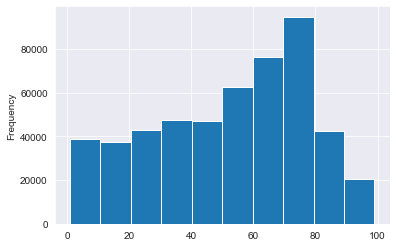

In [24]:
NFL.YardsLeft.plot(kind='hist')

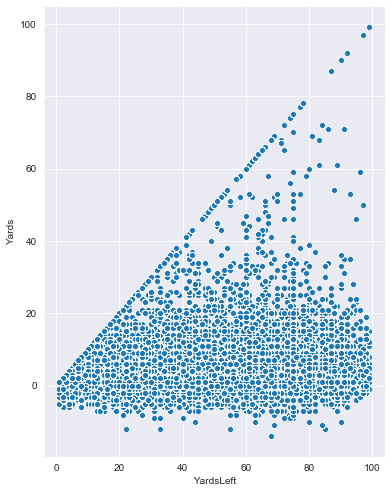

In [25]:
sns.pairplot(NFL, x_vars=['YardsLeft'], y_vars='Yards', size=7, aspect=0.8)

## Tactics and Formulation: Down
- Yards gained by down: we could see that as down increases, the average yards gained decrease

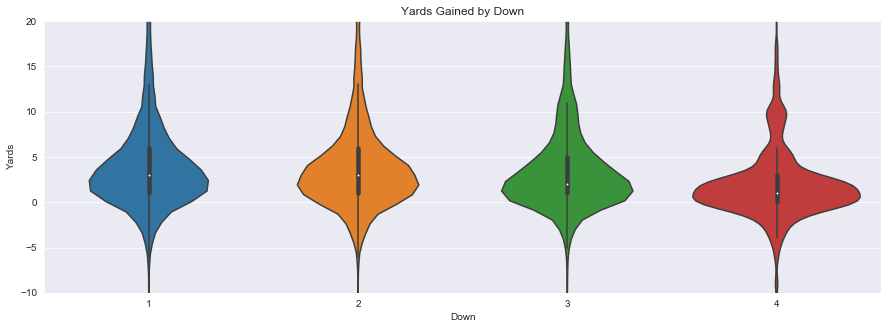

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(x='Down',
               y='Yards',
               data=NFL.rename(columns={'Down':'Down'}),
               ax=ax)
plt.ylim(-10, 20)
plt.title('Yards Gained by Down')
plt.show()

## Tactics and Formulation: Defenders In The "Box"
- The number of defenders in the box is an important part of stopping the running game. Typically defenses will add more players to this area of the field when they really want to stop a run, this comes at a cost leaving wide recievers less covered.
- Wow! This plot shows a big difference in yards gained when looking at the number of defenders in the box. If you've got 8+ defenders in the box you're looking to stop the run big time! And you can see the average rush yardage is lower. Conversely having 3 men in the box (maybe because they are in prevent defense for a long yard to gain) allows for a average return of about 10 yards!   

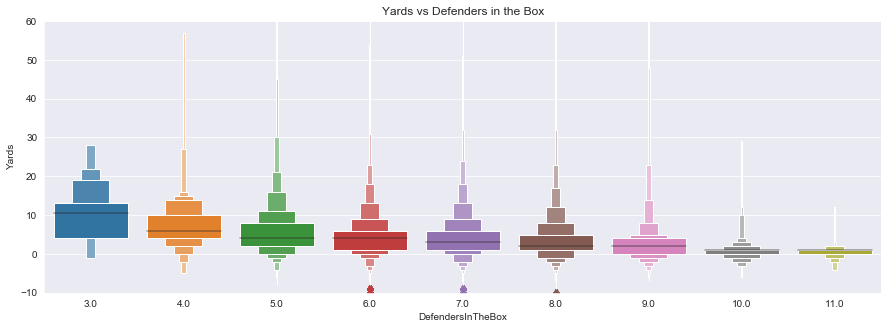

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_ylim(-10, 60)
sns.boxenplot(x='DefendersInTheBox',
               y='Yards',
               data=NFL.query('DefendersInTheBox > 2'),
               ax=ax)
plt.title('Yards vs Defenders in the Box')
plt.show()

- Distribution of Yards gained vs Defenders in the Box
- We can clearly see some variation in yards gained depending on the number of defenders in the box.

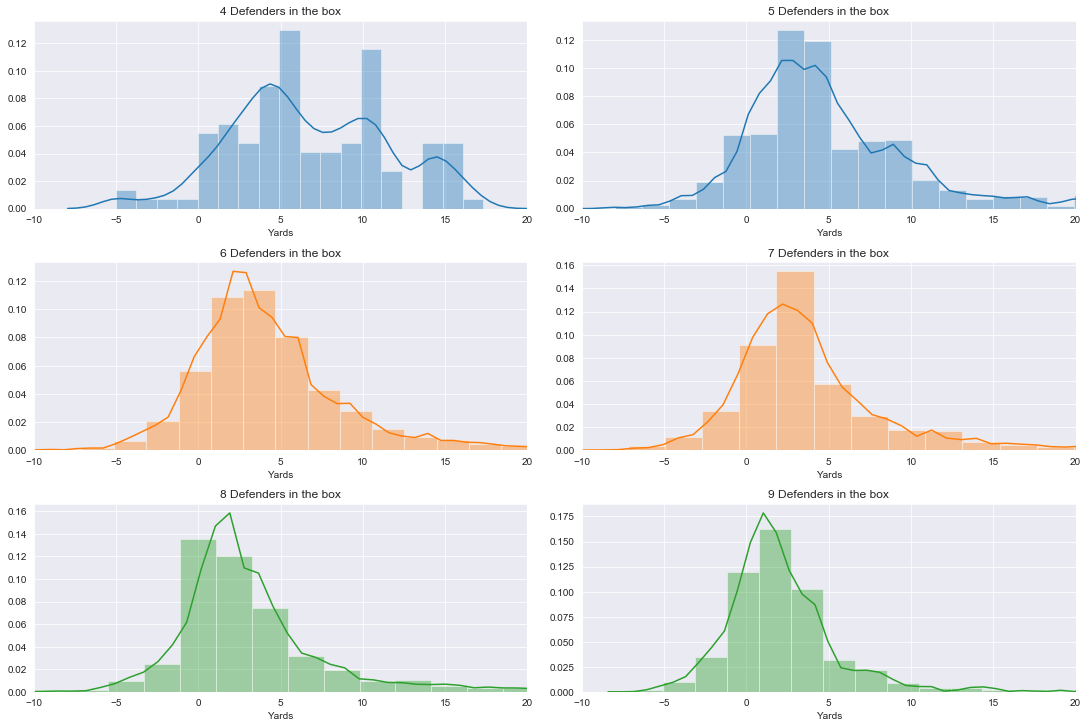

In [28]:
fig, axes = plt.subplots(3, 2, constrained_layout=True, figsize=(15 , 10))
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
#fig.tight_layout()
ax_idx = 0
ax_idx2 = 0
for i in range(4, 10):
    this_ax = axes[ax_idx2][ax_idx]
    #print(ax_idx, ax_idx2)
    sns.distplot(NFL.query('DefendersInTheBox == @i')['Yards'],
                ax=this_ax,
                color=color_pal[ax_idx2])
    this_ax.set_title(f'{i} Defenders in the box')
    this_ax.set_xlim(-10, 20)
    ax_idx += 1
    if ax_idx == 2:
        ax_idx = 0
        ax_idx2 += 1
plt.show()

<h2>Environmental Effect：Temperature Adaptation

In [29]:
# We need a binary variable to represent low temperature adaptation of each team
# First, add two columns -- origin city & origin province
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='ARI'),'OriginCity']='Glendale'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='ARI'),'OriginState']='AZ'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='ARI'),'OriginCity']='Glendale'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='ARI'),'OriginState']='AZ'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='ATL'),'OriginCity']='Atlanta'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='ATL'),'OriginState']='GA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='ATL'),'OriginCity']='Atlanta'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='ATL'),'OriginState']='GA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='BAL'),'OriginCity']='Baltimore'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='BAL'),'OriginState']='MD'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='BAL'),'OriginCity']='Baltimore'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='BAL'),'OriginState']='MD'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='WAS'),'OriginCity']='Landover'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='WAS'),'OriginState']='MD'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='WAS'),'OriginCity']='Landover'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='WAS'),'OriginState']='MD'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='TEN'),'OriginCity']='Nashville'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='TEN'),'OriginState']='TN'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='TEN'),'OriginCity']='Nashville'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='TEN'),'OriginState']='TN'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='TB'),'OriginCity']='Tampa'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='TB'),'OriginState']='FL'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='TB'),'OriginCity']='Tampa'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='TB'),'OriginState']='FL'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='SF'),'OriginCity']='Santa Clara'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='SF'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='SF'),'OriginCity']='Santa Clara'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='SF'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='SEA'),'OriginCity']='Seattle'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='SEA'),'OriginState']='WA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='SEA'),'OriginCity']='Seattle'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='SEA'),'OriginState']='WA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='PIT'),'OriginCity']='Pittsburgh'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='PIT'),'OriginState']='PA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='PIT'),'OriginCity']='Pittsburgh'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='PIT'),'OriginState']='PA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='PHI'),'OriginCity']='Philadelphia'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='PHI'),'OriginState']='PA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='PHI'),'OriginCity']='Philadelphia'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='PHI'),'OriginState']='PA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='OAK'),'OriginCity']='Oakland'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='OAK'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='OAK'),'OriginCity']='Oakland'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='OAK'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NYJ'),'OriginCity']='East Rutherford'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NYJ'),'OriginState']='NJ'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NYJ'),'OriginCity']='East Rutherford'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NYJ'),'OriginState']='NJ'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NYG'),'OriginCity']='East Rutherford'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NYG'),'OriginState']='NJ'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NYG'),'OriginCity']='East Rutherford'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NYG'),'OriginState']='NJ'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NO'),'OriginCity']='New Orleans'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NO'),'OriginState']='LA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NO'),'OriginCity']='New Orleans'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NO'),'OriginState']='LA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NE'),'OriginCity']='Foxborough'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='NE'),'OriginState']='MA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NE'),'OriginCity']='Foxborough'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='NE'),'OriginState']='MA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='MIN'),'OriginCity']='Minneapolis'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='MIN'),'OriginState']='MN'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='MIN'),'OriginCity']='Minneapolis'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='MIN'),'OriginState']='MN'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='MIA'),'OriginCity']='Miami Gardens'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='MIA'),'OriginState']='FL'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='MIA'),'OriginCity']='Miami Gardens'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='MIA'),'OriginState']='FL'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='LAC'),'OriginCity']='Carson'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='LAC'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='LAC'),'OriginCity']='Carson'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='LAC'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='LA'),'OriginCity']='Los Angeles'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='LA'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='LA'),'OriginCity']='Los Angeles'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='LA'),'OriginState']='CA'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='KC'),'OriginCity']='Kansas City'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='KC'),'OriginState']='MO'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='KC'),'OriginCity']='Kansas City'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='KC'),'OriginState']='MO'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='JAX'),'OriginCity']='Jacksonville'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='JAX'),'OriginState']='FL'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='JAX'),'OriginCity']='Jacksonville'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='JAX'),'OriginState']='FL'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='IND'),'OriginCity']='Indianapolis'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='IND'),'OriginState']='IN'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='IND'),'OriginCity']='Indianapolis'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='IND'),'OriginState']='IN'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='HOU'),'OriginCity']='Houston'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='HOU'),'OriginState']='TX'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='HOU'),'OriginCity']='Houston'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='HOU'),'OriginState']='TX'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='GB'),'OriginCity']='Green Bay'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='GB'),'OriginState']='WI'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='GB'),'OriginCity']='Green Bay'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='GB'),'OriginState']='WI'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='DET'),'OriginCity']='Detroit'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='DET'),'OriginState']='MI'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='DET'),'OriginCity']='Detroit'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='DET'),'OriginState']='MI'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='DEN'),'OriginCity']='Denver'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='DEN'),'OriginState']='CO'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='DEN'),'OriginCity']='Denver'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='DEN'),'OriginState']='CO'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='DAL'),'OriginCity']='Arlington'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='DAL'),'OriginState']='TX'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='DAL'),'OriginCity']='Arlington'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='DAL'),'OriginState']='TX'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CLE'),'OriginCity']='Cleveland'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CLE'),'OriginState']='OH'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CLE'),'OriginCity']='Cleveland'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CLE'),'OriginState']='OH'

NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CIN'),'OriginCity']='Cincinnati'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CIN'),'OriginState']='OH'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CIN'),'OriginCity']='Cincinnati'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CIN'),'OriginState']='OH'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CHI'),'OriginCity']='Chicago'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CHI'),'OriginState']='IL'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CHI'),'OriginCity']='Chicago'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CHI'),'OriginState']='IL'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CAR'),'OriginCity']='Charlotte'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='CAR'),'OriginState']='NC'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CAR'),'OriginCity']='Charlotte'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='CAR'),'OriginState']='NC'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='BUF'),'OriginCity']='Orchard Park'
NFL.loc[(NFL['Team']=='home') & (NFL['HomeTeamAbbr']=='BUF'),'OriginState']='NY'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='BUF'),'OriginCity']='Orchard Park'
NFL.loc[(NFL['Team']=='away') & (NFL['VisitorTeamAbbr']=='BUF'),'OriginState']='NY'
NFL.OriginState.unique()

array(['MO', 'MA', 'NJ', 'NY', 'GA', 'IL', 'MD', 'OH', 'PA', 'AZ', 'MI',
       'FL', 'TX', 'CA', 'TN', 'IN', 'WA', 'WI', 'NC', 'LA', 'MN', 'CO'],
      dtype=object)

In [30]:
# Second, by definition of sun belt and freezing temperature, we add the column.
NFL['TempAdapt']=1
NFL.loc[(NFL['OriginState']!='FL') &(NFL['OriginState']!='GA') &(NFL['OriginState']!='LA') &(NFL['OriginState']!='MD') &(NFL['OriginState']!='TX') &(NFL['OriginState']!='TN') & (NFL['Temperature']<=32),'TempAdapt']=0

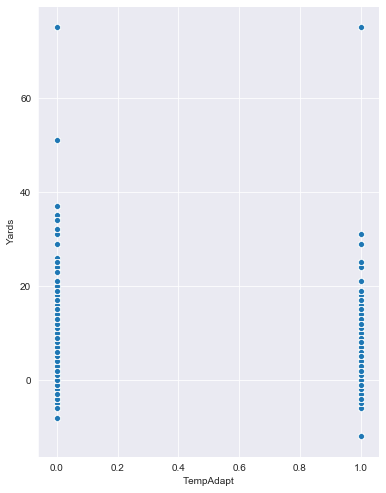

In [31]:
sns.pairplot(NFL[NFL['Temperature']<=32], x_vars=['TempAdapt'], y_vars='Yards', size=7, aspect=0.8)

<h2>Environmental Effect：Weather

In [32]:
# GameWeather - description of the game weather
# Cloudy Sunny Partly Cloudy Clear Rainy

# We are going to apply the following preprocessing:
# Lower case
# N/A Indoor, N/A (Indoors) and Indoor => indoor Let's try to cluster those together.
# coudy and clouidy => cloudy
# party => partly
# sunny and clear => clear and sunny
# skies and mostly => ""
NFL['GameWeather'] = NFL['GameWeather'].str.lower()
indoor = "indoor"
NFL['GameWeather'] = NFL['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
NFL['GameWeather'] = NFL['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
NFL['GameWeather'] = NFL['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
NFL['GameWeather'] = NFL['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
# Let's now look at the most common words we have in the weather description
from collections import Counter
weather_count = Counter()
for weather in NFL['GameWeather']:
    if pd.isna(weather):
        continue
    for word in weather.split():
        weather_count[word]+=1


def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0
NFL['GameWeather'] = NFL['GameWeather'].apply(map_weather)

<h2>Environmental Effect：Wind Direction

In [33]:
#data cleaning -- wind direction
# We change wind direction to 16 different values
NFL.loc[NFL['WindDirection']=='East','WindDirection']='E'
NFL.loc[NFL['WindDirection']=='EAST','WindDirection']='E'
NFL.loc[NFL['WindDirection']=='North','WindDirection']='N'
NFL.loc[NFL['WindDirection']=='Northwest','WindDirection']='NW'
NFL.loc[NFL['WindDirection']=='SouthWest','WindDirection']='SW'
NFL.loc[NFL['WindDirection']=='From SW','WindDirection']='SW'
NFL.loc[NFL['WindDirection']=='Southwest','WindDirection']='SW'
NFL.loc[NFL['WindDirection']=='Northeast','WindDirection']='NE'
NFL.loc[NFL['WindDirection']=='NorthEast','WindDirection']='NE'
NFL.loc[NFL['WindDirection']=='North East','WindDirection']='NE'
NFL.loc[NFL['WindDirection']=='From S','WindDirection']='S'
NFL.loc[NFL['WindDirection']=='South','WindDirection']='S'
NFL.loc[NFL['WindDirection']=='s','WindDirection']='S'
NFL.loc[NFL['WindDirection']=='South Southeast','WindDirection']='SSE'
NFL.loc[NFL['WindDirection']=='From SSE','WindDirection']='SSE'
NFL.loc[NFL['WindDirection']=='West','WindDirection']='W'
NFL.loc[NFL['WindDirection']=='from W','WindDirection']='W'
NFL.loc[NFL['WindDirection']=='From W','WindDirection']='W'
NFL.loc[NFL['WindDirection']=='South Southwest','WindDirection']='SSW'
NFL.loc[NFL['WindDirection']=='From SSW','WindDirection']='SSW'
NFL.loc[NFL['WindDirection']=='East North East','WindDirection']='ENE'
NFL.loc[NFL['WindDirection']=='Southeast','WindDirection']='SE'
NFL.loc[NFL['WindDirection']=='W-NW','WindDirection']='WNW'
NFL.loc[NFL['WindDirection']=='West Northwest','WindDirection']='WNW'
NFL.loc[NFL['WindDirection']=='From WSW','WindDirection']='WSW'
NFL.loc[NFL['WindDirection']=='W-SW','WindDirection']='WSW'
NFL.loc[NFL['WindDirection']=='West-Southwest','WindDirection']='WSW'
NFL.loc[NFL['WindDirection']=='From ESE','WindDirection']='ESE'
NFL.loc[NFL['WindDirection']=='East Southeast','WindDirection']='ESE'
NFL.loc[NFL['WindDirection']=='North/Northwest','WindDirection']='NNW'
NFL.loc[NFL['WindDirection']=='From NNW','WindDirection']='NNW'
NFL.loc[NFL['WindDirection']=='N-NE','WindDirection']='NNE'
NFL.loc[NFL['WindDirection']=='From NNE','WindDirection']='NNE'
NFL.loc[NFL['WindDirection']=='13','WindDirection']='SSW'
NFL.loc[NFL['WindDirection']=='8','WindDirection']='E'
NFL.loc[NFL['WindDirection']=='1','WindDirection']='SE'

<h2>Environmental Effect：Wind Speed

In [34]:
NFL.loc[NFL['WindSpeed']=='SSW','WindSpeed']=13
NFL.loc[NFL['WindSpeed']=='E','WindSpeed']=8
NFL.loc[NFL['WindSpeed']=='SE','WindSpeed']=1

In [35]:
NFL.loc[NFL['WindSpeed']=='10','WindSpeed']=10
NFL.loc[NFL['WindSpeed']=='5','WindSpeed']=5
NFL.loc[NFL['WindSpeed']=='6','WindSpeed']=6
NFL.loc[NFL['WindSpeed']=='4','WindSpeed']=4
NFL.loc[NFL['WindSpeed']=='0','WindSpeed']=13
NFL.loc[NFL['WindSpeed']=='11-17','WindSpeed']=14
NFL.loc[NFL['WindSpeed']=='16','WindSpeed']=16
NFL.loc[NFL['WindSpeed']=='14','WindSpeed']=14
NFL.loc[NFL['WindSpeed']=='12','WindSpeed']=12
NFL.loc[NFL['WindSpeed']=='23','WindSpeed']=23
NFL.loc[NFL['WindSpeed']=='7','WindSpeed']=7
NFL.loc[NFL['WindSpeed']=='9','WindSpeed']=9
NFL.loc[NFL['WindSpeed']=='3','WindSpeed']=3
NFL.loc[NFL['WindSpeed']=='17','WindSpeed']=17
NFL.loc[NFL['WindSpeed']=='10','WindSpeed']=10
NFL.loc[NFL['WindSpeed']=='14-23','WindSpeed']=18.5
NFL.loc[NFL['WindSpeed']=='1','WindSpeed']=1
NFL.loc[NFL['WindSpeed']=='13 MPH','WindSpeed']=13
NFL.loc[NFL['WindSpeed']=='15','WindSpeed']=15
NFL.loc[NFL['WindSpeed']=='12-22','WindSpeed']=17
NFL.loc[NFL['WindSpeed']=='2','WindSpeed']=2
NFL.loc[NFL['WindSpeed']=='4 MPh','WindSpeed']=4
NFL.loc[NFL['WindSpeed']=='15 gusts up to 25','WindSpeed']=20
NFL.loc[NFL['WindSpeed']=='11','WindSpeed']=11
NFL.loc[NFL['WindSpeed']=='10MPH','WindSpeed']=10
NFL.loc[NFL['WindSpeed']=='10mph','WindSpeed']=10
NFL.loc[NFL['WindSpeed']=='22','WindSpeed']=22
NFL.loc[NFL['WindSpeed']=='7 MPH','WindSpeed']=7
NFL.loc[NFL['WindSpeed']=='Calm','WindSpeed']=0
NFL.loc[NFL['WindSpeed']=='6 mph','WindSpeed']=6
NFL.loc[NFL['WindSpeed']=='19','WindSpeed']=19
NFL.loc[NFL['WindSpeed']=='20','WindSpeed']=20
NFL.loc[NFL['WindSpeed']=='10-20','WindSpeed']=15
NFL.loc[NFL['WindSpeed']=='12mph','WindSpeed']=12
NFL.loc[NFL['WindSpeed']=='8','WindSpeed']=8
NFL.loc[NFL['WindSpeed']=='13','WindSpeed']=13
NFL.loc[NFL['WindSpeed']=='18','WindSpeed']=18
NFL.loc[NFL['WindSpeed']=='24','WindSpeed']=24
NFL.loc[NFL['WindSpeed'].isna(),'WindSpeed']=0
NFL.WindSpeed=pd.to_numeric(NFL.WindSpeed)

In [36]:
WIND=NFL[['WindDirection','WindSpeed']].copy()
WIND.loc[WIND['WindDirection']=='N','WindDirection']=0
WIND.loc[WIND['WindDirection']=='NNE','WindDirection']=22.5
WIND.loc[WIND['WindDirection']=='NE','WindDirection']=45
WIND.loc[WIND['WindDirection']=='ENE','WindDirection']=67.5
WIND.loc[WIND['WindDirection']=='E','WindDirection']=90
WIND.loc[WIND['WindDirection']=='ESE','WindDirection']=112.5
WIND.loc[WIND['WindDirection']=='SE','WindDirection']=135
WIND.loc[WIND['WindDirection']=='SSE','WindDirection']=157.5
WIND.loc[WIND['WindDirection']=='S','WindDirection']=180
WIND.loc[WIND['WindDirection']=='SSW','WindDirection']=202.5
WIND.loc[WIND['WindDirection']=='SW','WindDirection']=225
WIND.loc[WIND['WindDirection']=='WSW','WindDirection']=247.5
WIND.loc[WIND['WindDirection']=='W','WindDirection']=270
WIND.loc[WIND['WindDirection']=='WNW','WindDirection']=292.5
WIND.loc[WIND['WindDirection']=='NW','WindDirection']=315
WIND.loc[WIND['WindDirection']=='NNW','WindDirection']=337.5
WIND.loc[WIND['WindDirection']=='Calm','WindDirection']=np.nan
WIND.WindDirection=pd.to_numeric(WIND.WindDirection)

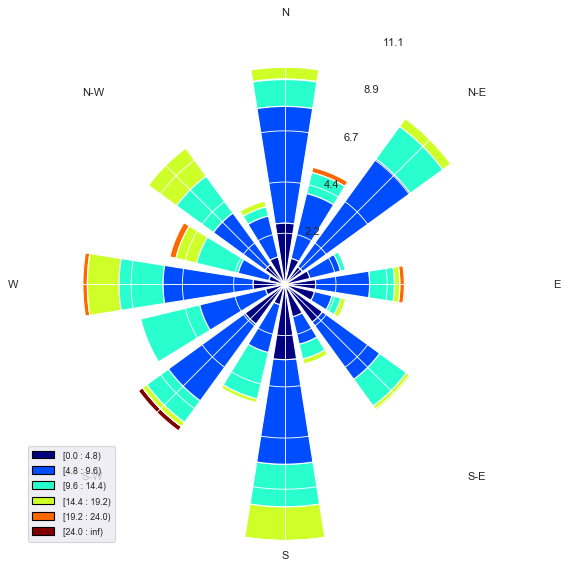

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes
from windrose import wrscatter
def plotPollutionRoseDemo(value,direction,save_path='demo.png'):
    ax=WindroseAxes.from_ax()
    ax.bar(direction,value,normed=True,opening=0.8,edgecolor='white')
    #wrscatter(direction,value, ax=ax, rmax=None)
    ax.set_legend()
    plt.savefig(save_path)
plotPollutionRoseDemo(WIND.WindSpeed,WIND.WindDirection)


<h2>Other Variables Cleaning

<h2>Plot the Graph

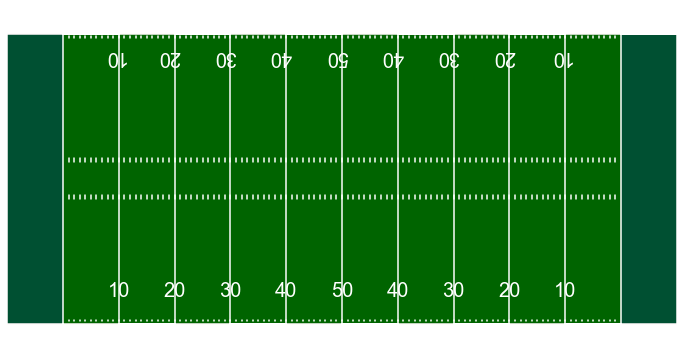

In [38]:
#Reference :#https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position
# Draw grass

import matplotlib.patches as patches

def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

## Image ploting for every play
- Red Point: Rusher of the offensive team
- Orange Point: Players of the offensive team except the rusher
- Blue Point: Players of the defensive team 
- Arrow: The direction of the arrow means the player's running direction. Start and end of the arrow is the player's original and final position in that play. The length of the arrow is the player's running distance.

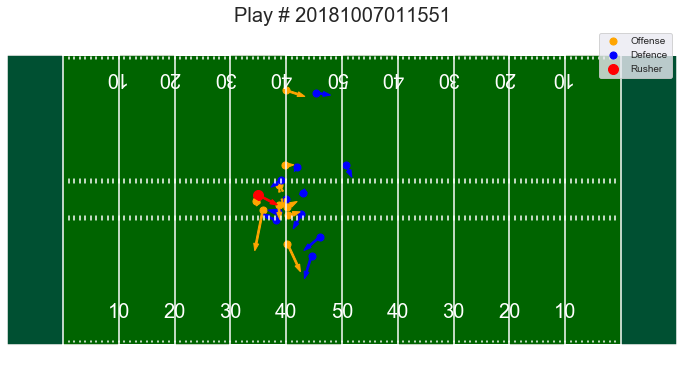

In [39]:
import math
def get_dx_dy(angle, dist):
    cartesianAngleRadians = (450-angle)*math.pi/180.0
    dx = dist * math.cos(cartesianAngleRadians)
    dy = dist * math.sin(cartesianAngleRadians)
    return dx, dy   


play_id = 20181007011551 #play_id
fig, ax = create_football_field()
rusher_row = NFL.query("PlayId == @play_id and NflIdRusher == NflId")
yards_covered = rusher_row["Yards"].values[0]
possession = rusher_row['Team'].iloc[0]
NFL[(NFL.PlayId == play_id) & (NFL.Team == possession)] \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=50, label='Offense')
NFL[(NFL.PlayId == play_id) & (NFL.Team != possession)]  \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=50, label='Defence')
NFL.query("PlayId == @play_id and NflIdRusher == NflId") \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='red', s=100, label='Rusher')

#draw the legend
plt.legend(['Offense','Defence','Rusher'])

x = rusher_row["X"].values[0]
y = rusher_row["Y"].values[0]
rusher_dir = rusher_row["Dir"].values[0]
rusher_speed = rusher_row["S"].values[0]
dx, dy= get_dx_dy(rusher_dir, rusher_speed)

ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3,fc='red',ec='red')

play_df=NFL[NFL['PlayId'] == play_id]
for i in range(22):
    not_rusher_row = play_df.iloc[i]
    if not_rusher_row['NflIdRusher'] == not_rusher_row['NflId']:
        continue
    x = not_rusher_row["X"]
    y = not_rusher_row["Y"]
    not_rusher_dir = not_rusher_row["Dir"]
    not_rusher_speed = not_rusher_row["S"]
    dx, dy = get_dx_dy(not_rusher_dir, not_rusher_speed)
    if not_rusher_row['Team'] == possession:
        color = 'orange'
    else:
        color = 'blue'
    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3,fc=color,ec=color)
    
    
plt.title(f'Play # {play_id}', fontsize=20)
plt.legend()
plt.show()

## PNG for Every Play: 
- Describe the movement of every player in one play. According to the movement, we could use mathematical models to calculate the 'score' variable: At every 0.2 second, the closer offensive team member to the rusher, the higher the score, the closer defensive team member to the rusher, the lower the score. (Because the offensive team members would provide help to the rusher, the opposite the defensive team members)
- NOTE: This will generate a png document in certain folder: please check the current folder
- NOTE: Using the code we could draw png for every play by changing play_id. Here we just give an example.
- NOTE: After running the code below, you could see 'created_gif.gif' in the current folder, if it can not move, please use Chrome to open it. Also you can see the png documents created in the 'png' folder.

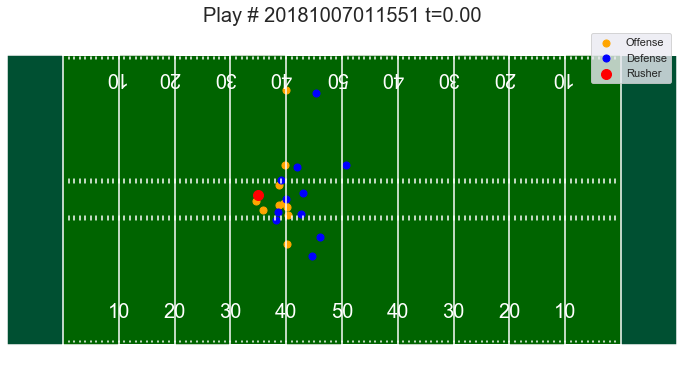

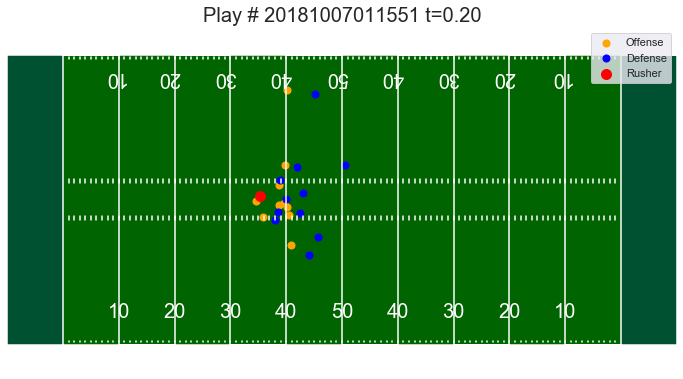

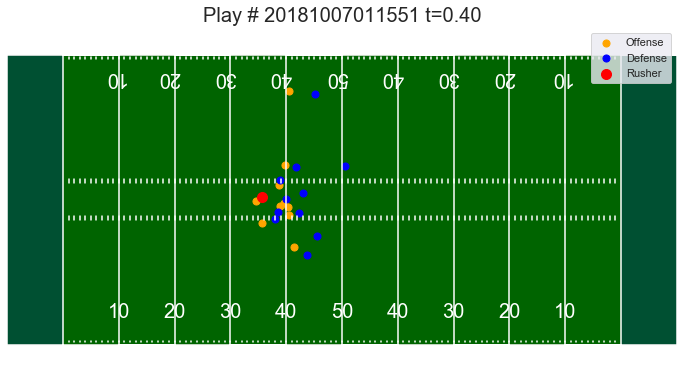

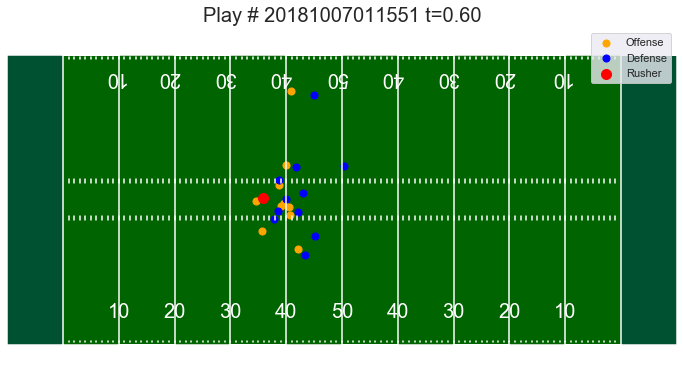

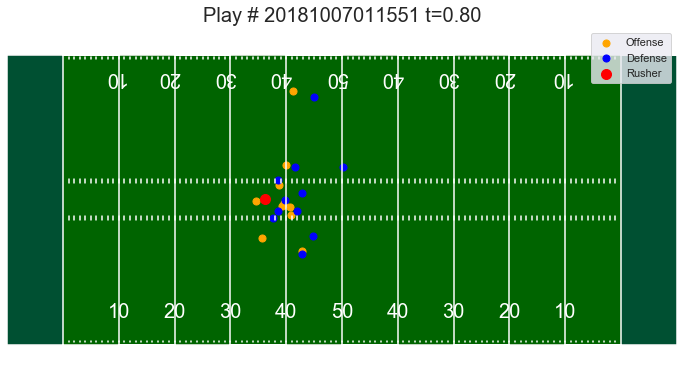

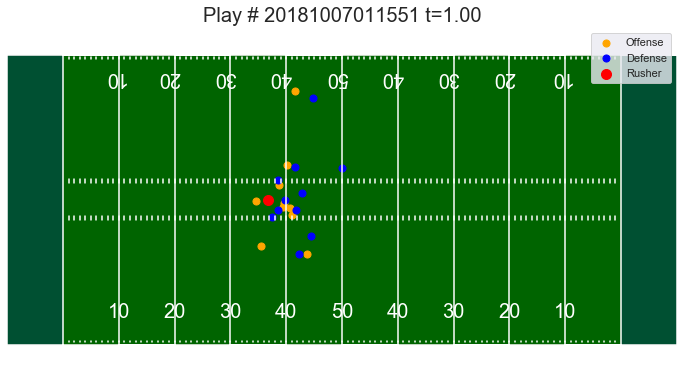

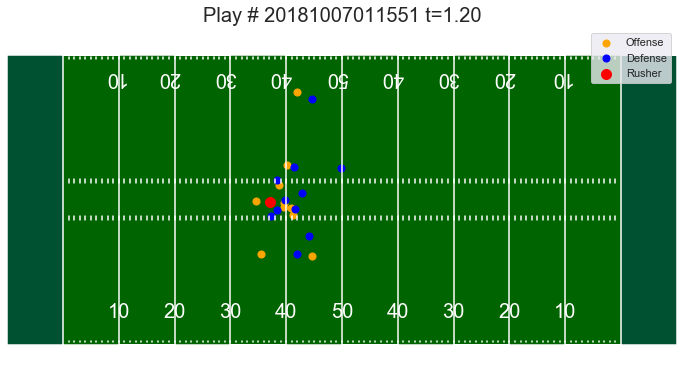

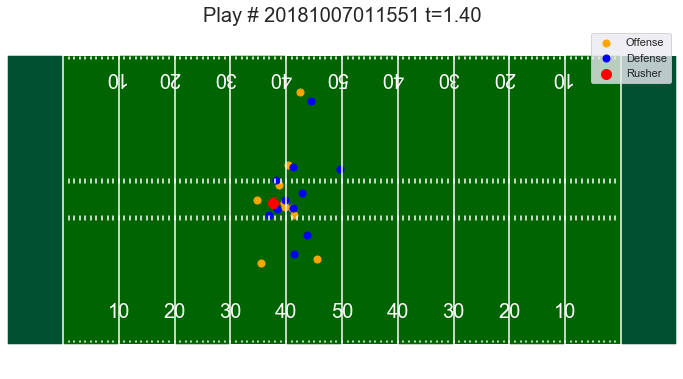

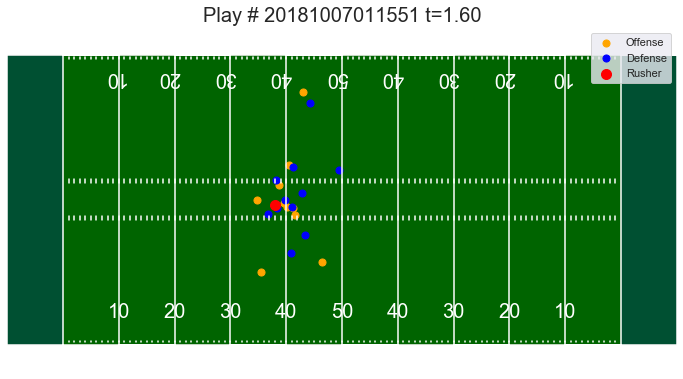

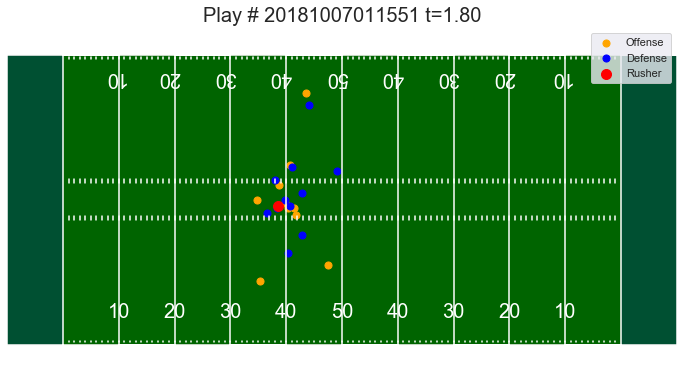

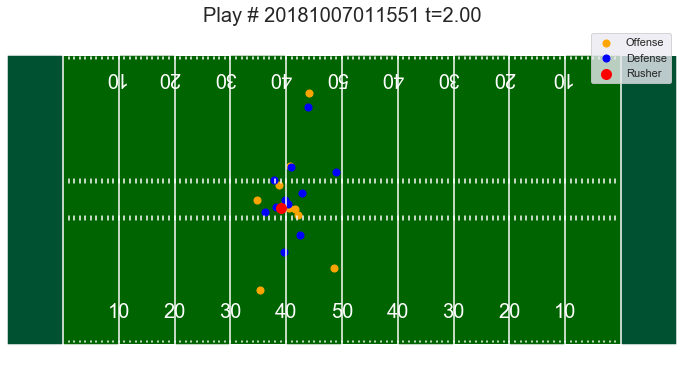

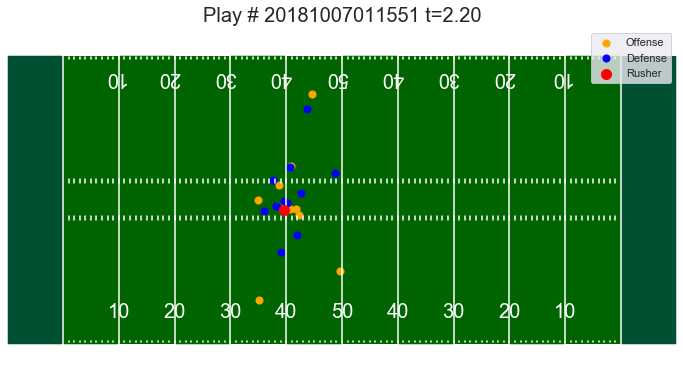

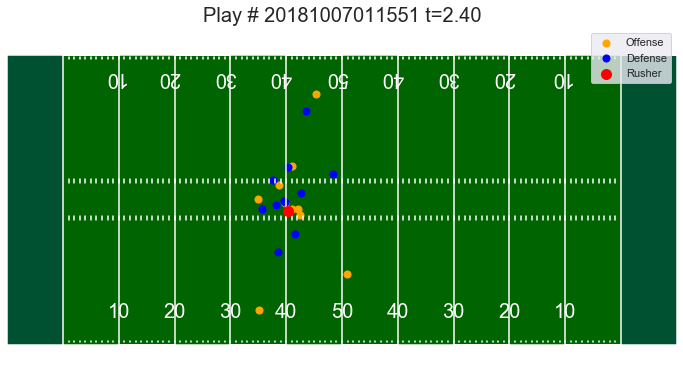

/Users/lvyue/Desktop/data analytics/NFL/png/.DS_Store
/Users/lvyue/Desktop/data analytics/NFL/png/A.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/B.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/C.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/D.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/E.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/F.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/G.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/H.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/I.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/J.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/K.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/L.png
None
/Users/lvyue/Desktop/data analytics/NFL/png/M.png
None


In [334]:
# For gif ploting 
# First, create dataframe for each play
import math
import os,sys
import imageio
import os
import os.path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# For gif ploting 
# First, create dataframe for each play
play_id = 20181007011551
timepos = NNFL[NNFL.PlayId == play_id]# Here we assume a play and try to construct our dataframe with time and everyone's position
timepos['t']=[0]*22#For every time t, we have 22 players' information, which requires 22 rows. Our t starts from zero
timepos['xt']=np.NaN
timepos['yt']=np.NaN
t = 3#
timepos_archive=timepos.copy()


for i in range(1,int(t/0.2)+1):#our t starts from 0
    new_df=timepos_archive.copy()
    new_df['t']=0.2*i
    timepos=pd.concat([timepos,new_df]) 
timepos.reset_index(inplace=True)
timepos.drop(['index'],axis=1,inplace=True)

#Second, we change value for xt and yt
"""
    task: xt = dx * t + X
          yt = dy * t + Y
"""
import math
def get_dx_dy(angle, dist):
    cartesianAngleRadians = (450-angle)*math.pi/180.0
    dx = dist * math.cos(cartesianAngleRadians)
    dy = dist * math.sin(cartesianAngleRadians)
    return dx, dy

xt = "xt"
angle = "Orientation"
dis = "Dis"
X = "X"
Y = "Y"
t = "t"
yt = "yt"

for i in range(len(timepos)):
    
    orientation = timepos[angle][i]
    dist = timepos[dis][i]
    S=timepos['S'][i]
    A=timepos['A'][i]
    dx, dy = get_dx_dy(orientation,dist)
    
    X = timepos['X'][i]
    Y = timepos['Y'][i]
    t = timepos['t'][i]
    
    timepos[xt][i] = dx * t * S + dx * t**2 * A / 2 + X
    timepos[yt][i] = dy * t * S + dy * t**2 * A / 2 + Y
timepos[xt]

# # Third, draw png

t=3
for i in [0.2*t for t in range(13)]:
    #print(i)
    fig, ax = create_football_field()
    rusher_row = timepos.query("t == @i and NflIdRusher == NflId")
#     yards_covered = rusher_row["Yards"].values[0]
    possession = rusher_row['Team'].iloc[0]
    #print(timepos[(timepos.Team == possession) & (timepos.t == i)])
    timepos[(timepos.Team == possession) & (timepos.t == i)] \
        .plot(x='xt', y='yt', kind='scatter', ax=ax, color='orange', s=50, label='Offense',zorder=2)
    timepos[(timepos.Team != possession) & (timepos.t == i)]  \
        .plot(x='xt', y='yt', kind='scatter', ax=ax, color='blue', s=50, label='Defense',zorder=2)
    timepos.query("t == @i and NflIdRusher == NflId") \
        .plot(x='xt', y='yt', kind='scatter', ax=ax, color='red', s=100, label='Rusher',zorder=3)

    #draw the legend
    plt.legend(['Offense','Defense','Rusher'])  

    plt.title(f'Play # {play_id} t={i:.2f}', fontsize=20)
    plt.legend()
    plt.savefig('./png/'+chr(65+int(5*i))+'.png')
    plt.show()

# Fourth, create gif
def create_gif(gif_name, path, duration = 0.3):

    frames = []
    pngFiles = os.listdir(path)
    image_list = [os.path.join(path, f) for f in pngFiles]
    image_list=sorted(image_list)
    for image_name in image_list:
        print(image_name)
        if image_name.endswith('.png'):
            try:
                img = Image.open(image_name) # open the image file
                print(img.verify()) # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                print('Bad file:', image_name)
            frames.append(imageio.imread(image_name))
    # save as gif 
    imageio.mimsave(gif_name, frames, 'GIF', duration = duration)

    return

import sys
gif_name = 'created_gif.gif'
path = sys.path[0] + '/png/'     # You could see the png documents in the 'png' folder
try:
    os.mkdir(path)
except FileExistsError:
    pass

duration = 0.5
create_gif(gif_name, path, duration)
# Because the movement changed slightly between each 0.2 seconds, it maybe a little difficult to see see movement from the graphs below
# You could see 'created_gif.gif' in the current folder, if it can not move, please use Chrome to open it. 
# Also you can see the png documents created in the 'png' folder.

<h2> Deal with the name error of teams

In [41]:
# data cleaning -- possession team 
NFL.loc[(NFL['PossessionTeam']=='BLT'), 'PossessionTeam']='BAL'
NFL.loc[(NFL['PossessionTeam']=='ARZ'), 'PossessionTeam']='ARI'
NFL.loc[(NFL['PossessionTeam']=='CLV'), 'PossessionTeam']='CLE'
NFL.loc[(NFL['PossessionTeam']=='HST'), 'PossessionTeam']='HOU'

In [42]:
NFL.drop(columns=['RushDis'],axis=1,inplace=True)

## Let's see the category features


In [43]:
cat_features = []
for col in NFL.columns:
    if NFL[col].dtype =='object':
        cat_features.append((col, len(NFL[col].unique())))

In [44]:
cat_features

[('Team', 2),
 ('DisplayName', 2230),
 ('GameClock', 901),
 ('PossessionTeam', 32),
 ('FieldPosition', 33),
 ('OffenseFormation', 9),
 ('OffensePersonnel', 56),
 ('DefensePersonnel', 38),
 ('PlayDirection', 2),
 ('PlayerCollegeName', 301),
 ('Position', 25),
 ('HomeTeamAbbr', 32),
 ('VisitorTeamAbbr', 32),
 ('Stadium', 55),
 ('Location', 60),
 ('StadiumType', 30),
 ('Turf', 20),
 ('WindDirection', 18),
 ('OriginCity', 31),
 ('OriginState', 22)]

## Stadium type

In [45]:
#stadium type
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt
NFL['StadiumType'] = NFL['StadiumType'].apply(clean_StadiumType)

def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    
    return np.nan
NFL['StadiumType'] = NFL['StadiumType'].apply(transform_StadiumType)

## Turf type
- Turf - description of the field surface
- Field Turf=FieldTurf
- Natural Grass=Natural grass=Natruall Grass=natural grass=Natural
- We divide the turf type into artificial and natural

In [46]:
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

NFL['Turf'] = NFL['Turf'].map(Turf)
NFL['Turf'] = NFL['Turf'] == 'Natural'

## Possession Team
- Team who carries the ball (Offense Team)

In [47]:
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in NFL['PossessionTeam'].unique():
    map_abbr[abb] = abb
NFL['PossessionTeam'] = NFL['PossessionTeam'].map(map_abbr)
NFL['HomeTeamAbbr'] = NFL['HomeTeamAbbr'].map(map_abbr)
NFL['VisitorTeamAbbr'] = NFL['VisitorTeamAbbr'].map(map_abbr)
NFL['HomePossesion'] = NFL['PossessionTeam'] == NFL['HomeTeamAbbr']
NFL['Field_eq_Possession'] = NFL['FieldPosition'] == NFL['PossessionTeam']
NFL['HomeField'] = NFL['FieldPosition'] == NFL['HomeTeamAbbr']

## Game Clock

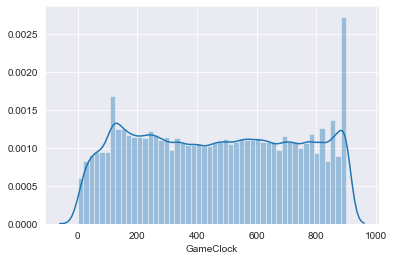

In [48]:
NFL['GameClock'].value_counts()
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans
NFL['GameClock'] = NFL['GameClock'].apply(strtoseconds)
sns.distplot(NFL['GameClock'])

## PlayDirection

In [49]:
NFL['PlayDirection'] = NFL['PlayDirection'].apply(lambda x: x.strip() == 'right')

## Team
- home or away, half and half
- Also marks the place on the field (left or right)

In [50]:
NFL['Team'] = NFL['Team'].apply(lambda x: x.strip()=='home')

## NflIdRusher
- A unique identifier of the player
- 22 players (22 different NflId) on the field for each different PlayId 
- Only 1 NflIdRusher on the field each time.

In [51]:
NFL['IsRusher'] = NFL['NflId'] == NFL['NflIdRusher']
NFL.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)

## PlayDirection problems
- X, orientation and direction
- Range 0 to 360 
- The direction that the player is facing when he hasn't moved. The direction is expressed by angles
- Orientation + 1/2 dir ~ relationship with winddirection

In [52]:
NFL['X'] = NFL.apply(lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)
#Reference : https://www.kaggle.com/scirpus/hybrid-gp-and-nn
def new_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
    
NFL['Orientation'] = NFL.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
NFL['Dir'] = NFL.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)

## Offense Formation

In [53]:
#offense formation
off_form = NFL['OffenseFormation'].unique()
NFL['OffenseFormation'].value_counts()
NFL = pd.concat([NFL.drop(['OffenseFormation'], axis=1), pd.get_dummies(NFL['OffenseFormation'], prefix='Formation')], axis=1)
dummy_col = NFL.columns

## Baseline model

In [54]:
NFL = NFL.sort_values(by=['PlayId', 'Team', 'IsRusher', 'JerseyNumber']).reset_index()
NFL.drop(['GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1, inplace=True)
cat_features = []
for col in NFL.columns:
    if NFL[col].dtype =='object':
        cat_features.append(col)
        
NFL = NFL.drop(cat_features, axis=1)

In [55]:
NFL = NFL[NFL['Yards']<=40]

# 2. Model training & Result Comparison

## K-Nearest Neighbor

In [60]:
#We are now going to make one big row for each play(flatten 22 rows into one row) where the rusher is the last one
NFL.fillna(-999, inplace=True)
players_col = []
for col in NFL.columns:
    if NFL[col][:22].std()>0.00001:
        players_col.append(col)
players_col

['X',
 'Y',
 'S',
 'A',
 'Dis',
 'Orientation',
 'Dir',
 'JerseyNumber',
 'PlayerHeight',
 'PlayerWeight',
 'PlayerBMI',
 'PlayerAge',
 'RusherTeam']

In [121]:
#Choosing variable
players_col=[
 'X',
 'Y',
 'S',
 'A',
 'Dis',
 'Orientation',
#  'Dir',
#  'JerseyNumber',
#  'PlayerHeight',
#  'PlayerWeight',
# 'RusherTeam',
 'PlayerBMI',
#  'PlayerAge'
]

In [122]:
play_col = NFL.drop(players_col+['Yards'], axis=1).columns
play_col

Index(['Dir', 'JerseyNumber', 'Season', 'YardLine', 'Quarter', 'GameClock',
       'Down', 'Distance', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'DefendersInTheBox', 'PlayDirection', 'PlayerHeight', 'PlayerWeight',
       'Week', 'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity',
       'WindSpeed', 'TimeDelta', 'PlayerAge', 'RusherX', 'RusherY', 'RusherS',
       'RusherA', 'RusherTeam', 'Score1', 'Score2', 'Score3', 'YardsLeft',
       'TempAdapt', 'HomePossesion', 'Field_eq_Possession', 'HomeField',
       'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
       'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
       'Formation_SINGLEBACK', 'Formation_WILDCAT'],
      dtype='object')

In [127]:
play_col=['Season', 'YardLine', 'Quarter',
       'GameClock', 'Down', 'Distance', 'DefendersInTheBox', 'PlayDirection', 'Week',
       'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity',
       'WindSpeed', 'TimeDelta', 'RusherX', 'RusherY', 'RusherS',
       'RusherA', 'RusherTeam', 'Score1', 'YardsLeft',
       'TempAdapt', 'HomePossesion','HomeField',
       'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
       'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
       'Formation_SINGLEBACK', 'Formation_WILDCAT']

In [128]:
X_train = np.array(NFL[players_col]).reshape(-1, len(players_col)*22)
X_play_col = np.zeros(shape=(X_train.shape[0], len(play_col)))

for i, col in enumerate(play_col):
    X_play_col[:, i] = NFL[col][::22]
X_train = np.concatenate([X_train, X_play_col], axis=1)
y_train = np.array(NFL['Yards'][::22])

In [129]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [130]:
#testX,testY: test set，trainX，trainY: train set
from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)
testX=X_train[int(0.9*len(X_train)):]
trainX=X_train[:int(0.9*len(y_train))]
testY=y_train[int(0.9*len(X_train)):]
trainY=y_train[:int(0.9*len(y_train))]

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from math import sqrt

k=800
knr=KNeighborsRegressor(n_neighbors=k)
knr.fit(trainX,trainY)
y_predict=knr.predict(testX)
mse=mean_squared_error(testY,y_predict)
rmse = sqrt(mse)
mae = mean_absolute_error(testY,y_predict)
  
print('The accuracy of K-Nearest Neighbor Regressor is',knr.score(testX,testY),k)
print('mse=',mse,'rmse=',rmse,'mae=',mae)

The accuracy of K-Nearest Neighbor Regressor is 0.029661694586455845 800
mse= 25.0653353143964 rmse= 5.00652926830518 mae= 3.434396944083225


## Random Forest

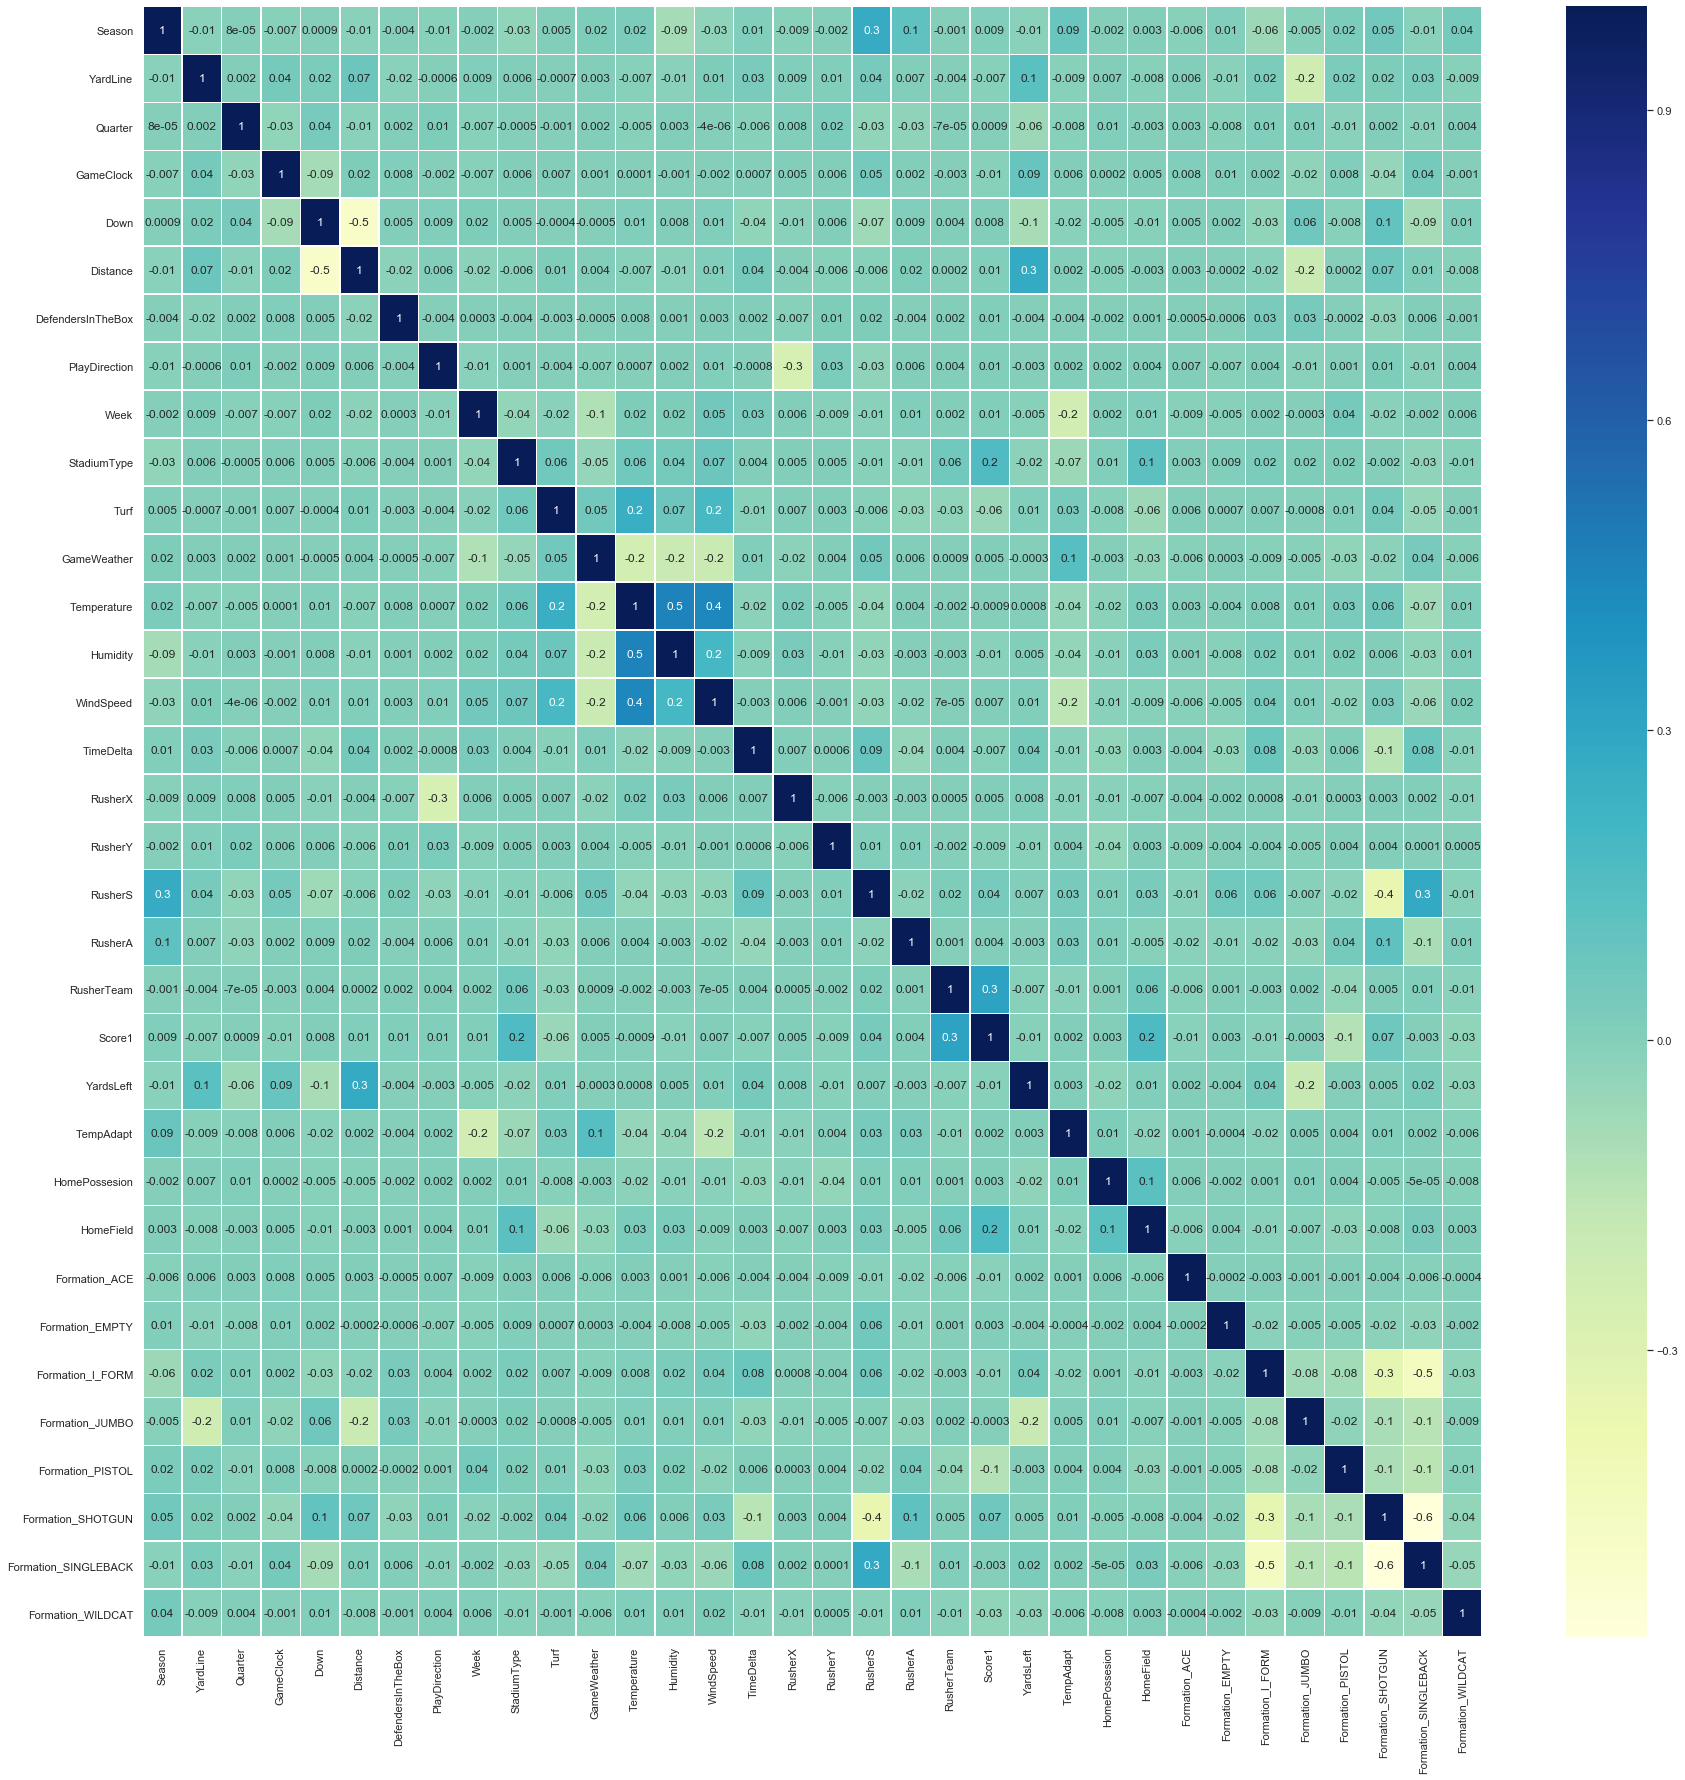

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(30, 30)})
corr = NFL[play_col].corr() 
plt.figure() 
ax = sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", fmt='.1g')
plt.savefig('corr_heatmap.png')
plt.show()

In [133]:
# Drop highly correlated features (37->30)
# Because we already use this method to drop all the highly correlated variables, 
# so it won't tell you "what should be dropped" again
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.5:
            if columns[j]:
                columns[j] = False

feature_columns =NFL[play_col].columns[columns].values
drop_columns = NFL[play_col].columns[columns == False].values
print(feature_columns)
print('-'*73)
print(drop_columns)

['Season' 'YardLine' 'Quarter' 'GameClock' 'Down' 'Distance'
 'DefendersInTheBox' 'PlayDirection' 'Week' 'StadiumType' 'Turf'
 'GameWeather' 'Temperature' 'Humidity' 'WindSpeed' 'TimeDelta' 'RusherX'
 'RusherY' 'RusherS' 'RusherA' 'RusherTeam' 'Score1' 'YardsLeft'
 'TempAdapt' 'HomePossesion' 'HomeField' 'Formation_ACE' 'Formation_EMPTY'
 'Formation_I_FORM' 'Formation_JUMBO' 'Formation_PISTOL'
 'Formation_SHOTGUN' 'Formation_SINGLEBACK' 'Formation_WILDCAT']
-------------------------------------------------------------------------
[]


In [169]:
#Choosing variable
players_col=[
 'X',
#  'Y',
 'S',
 'A',
 'Dis',
 'Orientation',
#  'Dir',
#  'JerseyNumber',
 'PlayerHeight',
 'PlayerWeight',
 'RusherTeam',
 'PlayerBMI',
 'PlayerAge'
]

In [173]:
play_col = ['Season', 'YardLine', 'Quarter',
       'GameClock', 'Down', 'Distance', 'DefendersInTheBox', 'PlayDirection',
       'StadiumType', 'Turf', 'GameWeather', 'Temperature', 'Humidity',
       'WindSpeed', 'TimeDelta', 'RusherX', 'RusherY', 'RusherS',
       'RusherA', 'RusherTeam', 'Score2', 'YardsLeft',
       'TempAdapt', 'HomePossesion','HomeField',
       'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
       'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
       'Formation_SINGLEBACK', 'Formation_WILDCAT']

In [174]:
X_train = np.array(NFL[players_col]).reshape(-1, len(players_col)*22)
X_play_col = np.zeros(shape=(X_train.shape[0], len(play_col)))

for i, col in enumerate(play_col):
    X_play_col[:, i] = NFL[col][::22]
X_train = np.concatenate([X_train, X_play_col], axis=1)
y_train = np.array(NFL['Yards'][::22])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)
testX=X_train[int(0.9*len(X_train)):]
trainX=X_train[:int(0.9*len(y_train))]
testY=y_train[int(0.9*len(X_train)):]
trainY=y_train[:int(0.9*len(y_train))]


- THIS WILL COST YOU A LOT OF TIME TO RUN IT! 

In [172]:
# finding best ensemble

# from sklearn.model_selection import GridSearchCV
# parameters = {
#      'n_estimators':(10,20), #the number of trees       
#      'max_depth':(4,6,8),
#      'min_samples_split': (2, 4, 8),   
#      'min_samples_leaf': (4,8,12,16)   
# }

# model = GridSearchCV(RandomForestRegressor(),parameters,cv=3,iid=False)
# model.fit(trainX, np.ravel(trainY))
# model.best_score_, model.best_params_

In [175]:
# Random forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rgr = RandomForestRegressor(n_estimators=20, max_depth=8,min_samples_leaf=12,min_samples_split=8)
rgr.fit(trainX,np.ravel(trainY))
y_pred=rgr.predict(testX)

In [177]:
# Show feature importance
import matplotlib.pyplot as plt
%matplotlib inline
# features_list = trainX.columns.values
feature_importance = rgr.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx

array([252,  27, 117, 217,  35,  37, 251, 127,  77,  87, 197,  47, 137,
       187,  57, 177, 147,  67, 167, 135, 107, 207, 157,  97, 243, 244,
         7, 245, 239, 234,  17, 246, 247, 248,  65, 250, 155,  55,  95,
       146,  75, 205,  15,  45, 227, 193, 229, 195, 148, 145, 178, 249,
       242, 125, 166, 186,  92, 232,  13, 230, 206, 222, 213, 215, 106,
        85, 188,  50, 218,  52, 228, 170, 175,  28, 105,  98, 154, 208,
       176, 113,  94, 118, 196,  59, 224,  43,  78,  40,  25,  14, 102,
       115,  99,  96, 183,  41,  16, 198, 120, 128,  36, 110, 126, 168,
        18, 203, 173,  24,  88, 165,  26, 158,  93, 184,  60,  33,   0,
        64,  81,  46,  58,  76, 160,  73, 216, 194, 153,  68, 108,  20,
        83,  10,   9, 143, 150, 156,  11, 119, 185,  84,   5,  56, 133,
       124, 240,   8,  38, 179,  23, 138, 139, 111, 172, 169,  82, 204,
        12,  19,  91, 210,  66,  54, 191, 134, 221,   4, 131,  42, 123,
       164, 104,  30,  48, 219, 136,  34,  29, 121, 174, 130, 16

In [182]:
pcol=players_col*22+play_col
inds=sorted_idx[-50:]
h=list()
p=list()
for i in inds:
    if pcol[i] not in h:
        h.append(pcol[i])
        p.append(i)
h

['Dis',
 'S',
 'WindSpeed',
 'PlayerAge',
 'Orientation',
 'A',
 'GameClock',
 'X',
 'RusherX',
 'YardsLeft',
 'RusherY',
 'DefendersInTheBox',
 'Season',
 'RusherS',
 'RusherA']

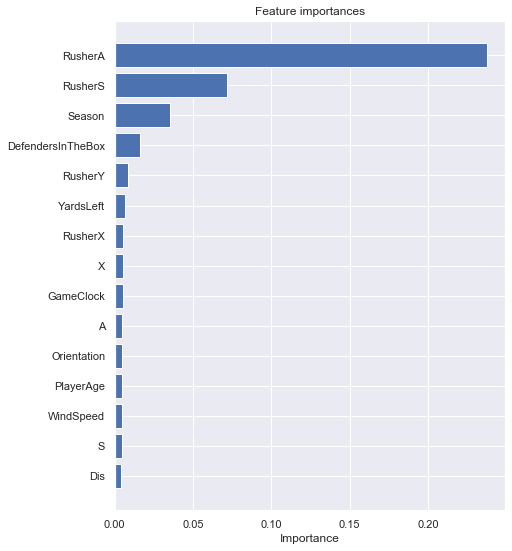

In [183]:
plt.figure(figsize=(7,9))
num=len(p)
plt.barh(range(num), feature_importance[p], align='center')
plt.yticks(range(num), h)
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

In [184]:
#mse
from sklearn.metrics import mean_squared_error
mean_squared_error(testY, y_pred)

25.306053173511337

In [185]:
#rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(testY, y_pred))

5.03051221780758

In [186]:
#mae
from sklearn.metrics import mean_absolute_error
y_pred=rgr.predict(testX)
mean_absolute_error(testY, y_pred)


3.2952569810860353

## LGBM

- If you can't import lgb below, you should run this code in terminal :
- conda install -c conda-forge lightgbm

In [200]:
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras #install
import lightgbm as lgb 
#import xgboost as xgb 
from tqdm import tqdm_notebook

from sklearn.metrics import accuracy_score,r2_score

### adjust parameters

In [201]:
#https://www.cnblogs.com/bjwu/p/9307344.html
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 

    'learning_rate': 0.1, 
    'num_leaves': 50, 
    'max_depth': 6,

    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    }
data_train = lgb.Dataset(X_train, y_train, silent=True)
cv_results = lgb.cv(
    params, data_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

[50]	cv_agg's rmse: 4.99058 + 0.150354
best n_estimators: 43
best cv score: 4.9889219804122


In [202]:
from sklearn.model_selection import GridSearchCV
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=50,
                              learning_rate=0.1, n_estimators=23, max_depth=6,
                              metric='rmse', bagging_fraction = 0.8,feature_fraction = 0.8)

params_test1={
    'max_depth': range(3,8,2),
    'num_leaves':range(50, 170, 30)
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)

In [203]:
gsearch1.fit(X_train, y_train)
#gsearch1.grid_scores_, 
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   31.9s finished


({'max_depth': 5, 'num_leaves': 50}, -25.00723450474355)

In [204]:
params_test2={
    'max_depth': [3,4,1,2,5],
    'num_leaves':[30,40,50,10,20]
}

gsearch2 = GridSearchCV(estimator=model_lgb, param_grid=params_test2, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch2.fit(X_train, y_train)
#gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   52.5s finished


({'max_depth': 5, 'num_leaves': 40}, -25.00723450474355)

In [205]:
params_test3={
    'min_child_samples': [18, 19, 20, 21, 22],
    'min_child_weight':[0.001, 0.002]
}
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.1, n_estimators=23, max_depth=4, 
                              metric='rmse', bagging_fraction = 0.8, feature_fraction = 0.8)
gsearch3 = GridSearchCV(estimator=model_lgb, param_grid=params_test3, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch3.fit(X_train, y_train)
#gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   23.8s finished


({'min_child_samples': 21, 'min_child_weight': 0.001}, -25.06217124273221)

In [206]:
params_test4={
    'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]
}
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.1, n_estimators=23, max_depth=4, 
                              metric='rmse', bagging_freq = 5,  min_child_samples=20,min_child_weight=0.001)
gsearch4 = GridSearchCV(estimator=model_lgb, param_grid=params_test4, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch4.fit(X_train, y_train)
#gsearch4.cv_results_, 
gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished


({'bagging_fraction': 1.0, 'feature_fraction': 0.9}, -25.03849365113642)

In [207]:
params_test5={
    'feature_fraction': [0.92,0.84,0.86,0.88,0.9,0.94]
}
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.1, n_estimators=23, max_depth=4, 
                              metric='rmse',  min_child_samples=20,min_child_weight=0.001,
                              bagging_fraction=0.9,feature_fraction=0.8)
gsearch5 = GridSearchCV(estimator=model_lgb, param_grid=params_test5, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch5.fit(X_train, y_train)
#gsearch5.cv_results_,
gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   13.3s finished


({'feature_fraction': 0.94}, -25.026040634721486)

In [208]:
params_test6={
    'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=30,
                              learning_rate=0.1, n_estimators=23, max_depth=4, 
                              metric='rmse',  min_child_samples=20,min_child_weight=0.001,
                              bagging_fraction=0.9,feature_fraction=0.92)
gsearch6 = GridSearchCV(estimator=model_lgb, param_grid=params_test6, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch6.fit(X_train, y_train)
#gsearch6.cv_results_, 
gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 245 out of 245 | elapsed:  1.7min finished


({'reg_alpha': 0.5, 'reg_lambda': 0.5}, -25.03037778851137)

In [209]:
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=30,
                              learning_rate=0.1, 
                              n_estimators=23,
                              max_depth=4, 
                              metric='rmse', 
                              min_child_samples=20,
                              min_child_weight=0.001,
                              bagging_fraction=0.9,
                              feature_fraction=0.92,
                             reg_alpha=0.08,
                              reg_lambda=0.08)
gsearch7 = GridSearchCV(estimator=model_lgb, param_grid=params_test6, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch7.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 245 out of 245 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(bagging_fraction=0.9, boosting_type='gbdt',
                                     class_weight=None, colsample_bytree=1.0,
                                     feature_fraction=0.92,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=4, metric='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=23, n_jobs=-1, num_leaves=30,
                                     ob...ion', random_state=None,
                                     reg_alpha=0.08, reg_lambda=0.08,
                                     silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=4,
       

### Now we already know the best parameters, use them to construct the model

In [211]:
X_train = np.array(NFL[players_col]).reshape(-1, len(players_col)*22)
X_play_col = np.zeros(shape=(X_train.shape[0], len(play_col)))

for i, col in enumerate(play_col):
    X_play_col[:, i] = NFL[col][::22]
X_train = np.concatenate([X_train, X_play_col], axis=1)
y_train = np.array(NFL['Yards'][::22])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
train=X_train

from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)
X_test=X_train[int(0.9*len(train)):]
X_train=X_train[:int(0.9*len(train))]
y_test=y_train[int(0.9*len(train)):]
y_train=y_train[:int(0.9*len(train))]

In [212]:
train_data=lgb.Dataset(X_train,label=y_train)

#setting parameters for lightgbm
params = {'objective':'regression',
          'num_leaves':20,
          'learning_rate':0.1, 
          'n_estimators':15, 
          'max_depth':7, 
          'metric':'rmse',  
          'min_child_samples':21,
          'min_child_weight':0.001,
          'bagging_fraction':1.0,
          'feature_fraction':0.9
    }

#Here we have set max_depth in xgb and LightGBM to 7 to have a fair comparison between the two.

#training our model using light gbm
num_round=1000
start=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
stop=datetime.now()

#Execution time of the model
execution_time_lgbm = stop-start
print(execution_time_lgbm)

#predicting on test set
ypred2=lgbm.predict(X_test)
print(ypred2[0:5])  # showing first 5 predictions


#calculating accuracy
accuracy_lgbm = r2_score(ypred2,y_test)
accuracy_lgbm
#y_test.value_counts()

from sklearn.metrics import mean_squared_error,mean_absolute_error

#calculating roc_auc_score for light gbm. 
mse_lgbm = mean_squared_error(y_test,ypred2)
#mse_lgbm_comparison_dict = {'accuracy score':accuracy_lgbm,'auc score':mse_lgbm}
#mean absolute error
mae_lgbm = mean_absolute_error(y_test,ypred2)

0:00:00.466489
[4.02709252 4.60746934 4.66737775 3.4853784  2.92941934]


In [223]:
print('MSE:'+ str(mse_lgbm) + '\nRMSE: ' + str(mse_lgbm**0.5) + '\nMAE: ' + str(mae_lgbm))

MSE:24.171916513222843
RMSE: 4.916494331657756
MAE: 3.2406428367122815


## SVM (Support Vector Machine)

In [225]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
linear_svr = SVR(kernel='linear')
linear_svr.fit(X_train, y_train)
linear_svr_y_predict = linear_svr.predict(X_test)
#predicting on test set

#calculating accuracy
accuracy_svr = r2_score(linear_svr_y_predict,y_test)
accuracy_svr
#y_test.value_counts()

from sklearn.metrics import mean_squared_error

#calculating roc_auc_score for light gbm. 
mse_svr = mean_squared_error(y_test,linear_svr_y_predict)

#mean absolute error
mae_svr = mean_absolute_error(y_test,linear_svr_y_predict)

In [226]:
print('MSE:' + str(mse_svr) + '\nRMSE: ' + str(mse_svr**0.5) + '\nMAE: ' + str(mae_svr))

MSE:25.435096467744266
RMSE: 5.043321967487726
MAE: 3.1335470079373207


## Poisson 

In [229]:
play_col = NFL.drop(players_col+['Yards'], axis=1).columns
play_col = ['Season', 'YardLine', 'Quarter', 'GameClock', 'Down', 'Distance',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'DefendersInTheBox',
       'PlayDirection', 'Week', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'RusherX',
       'RusherY', 'RusherS', 'RusherA', 
       'HomePossesion', 'Field_eq_Possession', 'HomeField', 'Formation_ACE',
       'Formation_EMPTY', 'Formation_I_FORM', 'Formation_JUMBO',
       'Formation_PISTOL', 'Formation_SHOTGUN', 'Formation_SINGLEBACK',
       'Formation_WILDCAT', 'TimeDelta', 'YardsLeft',
'Score3',]

In [230]:
X_train = np.array(NFL[players_col]).reshape(-1, len(players_col)*22)
X_play_col = np.zeros(shape=(X_train.shape[0], len(play_col)))

for i, col in enumerate(play_col):
    X_play_col[:, i] = NFL[col][::22]
X_train = np.concatenate([X_train, X_play_col], axis=1)
y_train = np.array(NFL['Yards'][::22])

In [279]:
NNFL=NFL.iloc[::22].copy()
offset=8
NNFL=NNFL[NNFL.Yards>=-offset]
NNFL=NNFL[NNFL.Yards<=32]
NNFL.Yards=NNFL.Yards+offset
NNFL.Season=NNFL.Season-2017

xx=NNFL[['Season', 'Week', 'Quarter', 'GameClock', 
         'Down', 'Distance', 'DefendersInTheBox', 'TimeDelta', 'YardsLeft',
         'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 
         'StadiumType', 'Turf', 
         'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 
         'RusherS', 'RusherA','Score3', 
         'HomePossesion', 'Field_eq_Possession', 'HomeField',
         'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
         'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
         'Formation_SINGLEBACK', 'Formation_WILDCAT']]
y=NNFL.Yards


def Neg_LL(betas):
  #include observed heterogeneity in lmbda
    lmbda=np.exp(betas[0]+np.sum(betas[1:]*xx,axis=1))
    Ind_L=spst.poisson.pmf(y,lmbda)
    Ind_LL=np.log(Ind_L)
    return -np.sum(Ind_LL)

import warnings
warnings.simplefilter("ignore")

guess=[2]+[0]*len(xx.columns)
model1=minimize(Neg_LL,guess, method="Nelder-Mead")
#model1=minimize(Neg_LL,guess, method="BFGS")
print(model1.fun)
print(model1.success)
print(np.exp(model1.x[0]))
betas=model1.x
lmbda=np.exp(betas[0]+np.sum(betas[1:]*xx,axis=1))
print(model1.x)

69478.2016959845
False
10.94925475356598
[ 2.39327139e+00  1.78964751e-02 -1.98032543e-03 -1.42840953e-02
  2.83221053e-05 -8.73216475e-03  6.62628690e-03 -4.88632599e-04
  3.32810574e-03  6.88821446e-04 -6.93346605e-04  2.02401225e-03
 -4.45279801e-06  4.68375122e-03  1.02139237e-03  1.27600398e-05
 -4.29395238e-05 -3.03118952e-03 -7.87200184e-03  2.93666795e-02
 -3.42675216e-04  9.03626211e-03 -8.47186044e-03  7.16634434e-04
 -2.47363555e-03 -4.51510210e-03 -2.94090168e-02 -2.90863670e-03
 -3.30350650e-03  6.01912054e-03 -4.92826887e-03  5.13209387e-03]


In [280]:
MSE = np.mean((y-lmbda)**2)  
MAE = np.mean(np.abs(y-lmbda))
print('MSE: ' + str(MSE) + '\nMAE: ' + str(MAE))

MSE: 24.028156520901792
MAE: 3.3939589666053247


In [281]:
lmbda0=np.mean(y)
lmbda0

11.885629732787883

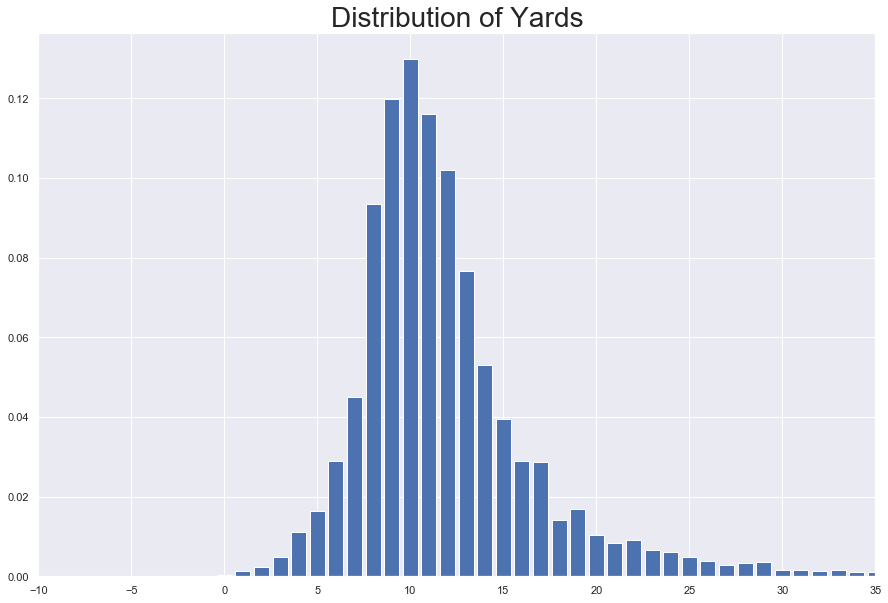

In [282]:
prediction = spst.poisson.pmf(y,lmbda0)
df=pd.DataFrame(prediction,y,columns={'Score'}).reset_index()
x=df.groupby('Yards').mean()['Score']

Tally=NNFL.groupby(["Yards"]).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values/len(NNFL),zorder=1)
#plt.scatter(x.index-offset,x.values,zorder=2,alpha=1)
plt.title('Distribution of Yards',fontsize=28)
plt.xlim(-10,35)
plt.show()

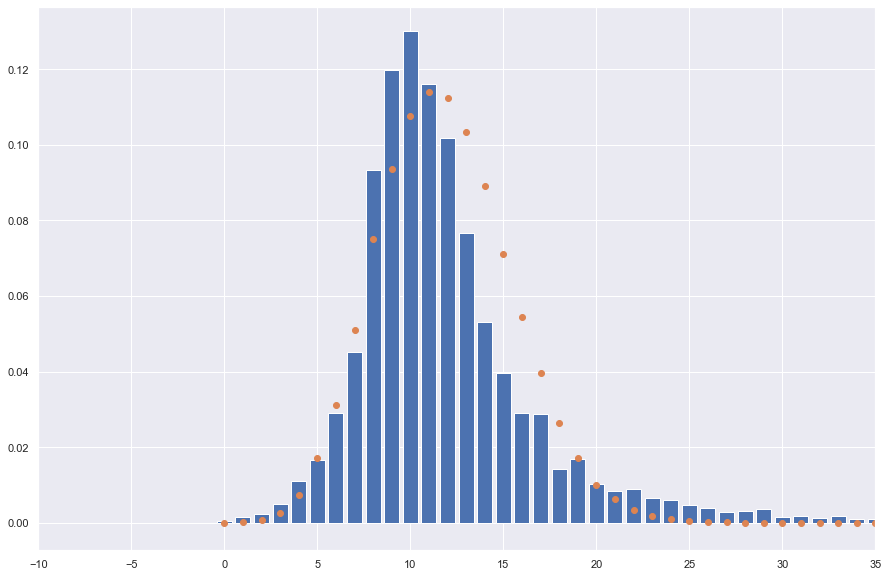

In [284]:
pmf=spst.poisson.pmf(y,lmbda)
prediction= pmf
df=pd.DataFrame(prediction,y,columns={'Score'}).reset_index()
x=df.groupby('Yards').mean()['Score']

Tally=NNFL.groupby(["Yards"]).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values/len(NNFL),zorder=1)
plt.scatter(x.index,x.values,zorder=2,alpha=1)
plt.xlim(-10,35)
plt.show()

## Weibull Model
- We tried many initial guess of parameters but the results do not converge. The reason maybe the sample size is too large.
- Then we tried fewer decision variables. We obtain reasonable results but not so good.

In [321]:
NNFL=NFL.iloc[::22].copy()
offset=8
NNFL=NNFL[NNFL.Yards>=-offset]
NNFL=NNFL[NNFL.Yards<=32]
NNFL.Yards=NNFL.Yards+offset
NNFL.Season=NNFL.Season-2017

xx=NNFL[['Season', 'Week', 'Quarter', 'GameClock', 
         'Down', 'Distance', 'DefendersInTheBox', 'TimeDelta', 'YardsLeft',
         'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 
         'StadiumType', 'Turf',
         'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 
         'RusherS', 'RusherA','Score3', 
         'HomePossesion', 'Field_eq_Possession', 'HomeField',
         'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
         'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
         'Formation_SINGLEBACK', 'Formation_WILDCAT']]

y=NNFL.Yards


def neg_LL(betas):
    c=np.exp(betas[0])
    lmbda=np.exp(betas[-1]+np.sum(betas[1:-1]*xx,axis=1))
    F_t=1-np.exp(-(y*lmbda)**c)
    F_t_m1=1-np.exp(-((y-1)*lmbda)**c)
  #censored patient
    Ind_Lc=1-F_t
  #uncensored
  #time we observed is round up to the closest integer
  #if treating time column as continuous
    f_t=(c*lmbda)*(y*lmbda)**(c-1)*np.exp(-(y*lmbda)**c)
    Ind_L=F_t-F_t_m1
    return -np.sum(np.log(Ind_L))


import scipy.special as spsp
guess=[0]+[0]*len(xx.columns)+[0]
model1=minimize(neg_LL,guess, method="Nelder-Mead")
#model1=minimize(neg_LL,guess, method="BFGS")
print(model1.fun)
print(model1.success)
print(np.exp(model1.x[0]))
betas=model1.x
c=np.exp(betas[0])
lmbda=np.exp(betas[-1]+np.sum(betas[1:-1]*xx,axis=1))
print(model1.x)
np.mean((y-lmbda*spsp.gamma(1+1/c))**2)

inf
False
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


143.1072330054835

In [286]:
NNFL=NFL.iloc[::22].copy()
offset=8
NNFL=NNFL[NNFL.Yards>=-offset]
NNFL=NNFL[NNFL.Yards<=32]
NNFL.Yards=NNFL.Yards+offset
NNFL.Season=NNFL.Season-2017

xx=NNFL[['Season', 'Week', 'Quarter', 'GameClock', 
         'Down', 'Distance', 'DefendersInTheBox', 'TimeDelta', 'YardsLeft',
         'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 
         'StadiumType', 'Turf',
         'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 
         'RusherS', 'RusherA','Score3', 
         'HomePossesion', 'Field_eq_Possession', 'HomeField',
         'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
         'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
         'Formation_SINGLEBACK', 'Formation_WILDCAT']]

y=NNFL.Yards


def neg_LL(betas):
    c=np.exp(betas[0])
    lmbda=np.exp(betas[-1])
    F_t=1-np.exp(-(y*lmbda)**c)
    F_t_m1=1-np.exp(-((y-1)*lmbda)**c)
    #yards we observed is round up to the closest integer
    #if treating time column as continuous
    f_t=(c*lmbda)*(y*lmbda)**(c-1)*np.exp(-(y*lmbda)**c)
    Ind_L=F_t-F_t_m1
    return -np.sum(np.log(Ind_L))


import scipy.special as spsp
guess=[-1]+[-1]
model1=minimize(neg_LL,guess, method="Nelder-Mead")
#model1=minimize(neg_LL,guess, method="BFGS")
print(model1.fun)
print(model1.success)
print(np.exp(model1.x[0]))
betas=model1.x
c=np.exp(betas[0])
lmbda=np.exp(betas[-1])
print(model1.x)
np.mean((y-lmbda*spsp.gamma(1+1/c))**2)

68261.42314160205
True
2.3676463927195646
[ 0.86189638 -2.55257887]


164.24248381255185

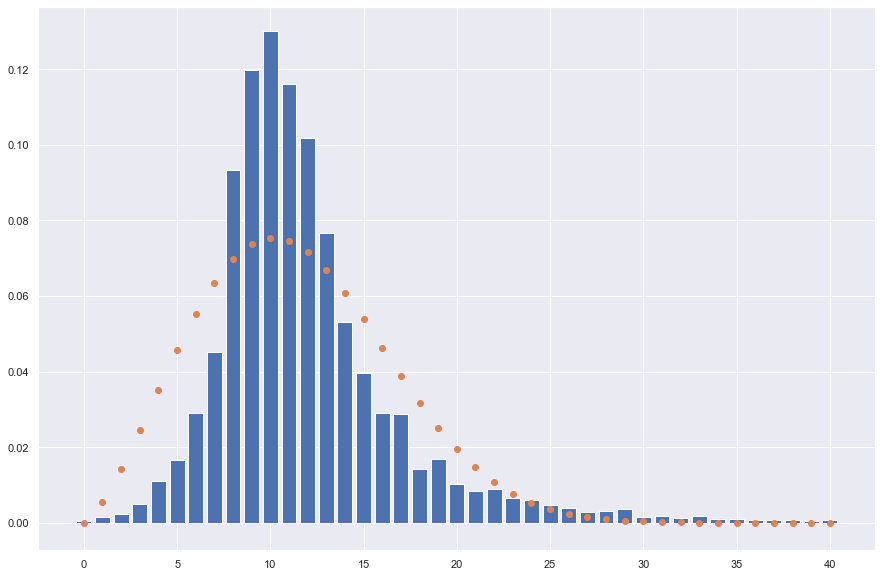

In [314]:
prediction= (c*lmbda)*(y*lmbda)**(c-1)*np.exp(-(y*lmbda)**c)
prediction.rename('Score',inplace=True)
df=pd.concat([y,prediction],axis=1)
x=df.groupby('Yards').mean()['Score']
Tally=NNFL.groupby(["Yards"]).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values/len(NNFL),zorder=1)
plt.scatter(x.index,x.values,zorder=2,alpha=1)
plt.show()

In [319]:
NNFL=NFL.iloc[::22].copy()
offset=8
NNFL=NNFL[NNFL.Yards>=-offset]
NNFL=NNFL[NNFL.Yards<=32]
NNFL.Yards=NNFL.Yards+offset
NNFL.Season=NNFL.Season-2017

xx=NNFL[[
         'RusherS', 'RusherA','Score3', 
         'HomePossesion', 'Field_eq_Possession', 'HomeField',
         'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
         'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
         'Formation_SINGLEBACK', 'Formation_WILDCAT']]

y=NNFL.Yards


def neg_LL(betas):
    c=np.exp(betas[0])
    lmbda=np.exp(betas[-1]+np.sum(betas[1:-1]*xx,axis=1))
    F_t=1-np.exp(-(y*lmbda)**c)
    F_t_m1=1-np.exp(-((y-1)*lmbda)**c)
    #yards we observed is round up to the closest integer
    #if treating time column as continuous
    f_t=(c*lmbda)*(y*lmbda)**(c-1)*np.exp(-(y*lmbda)**c)
    Ind_L=F_t-F_t_m1
    return -np.sum(np.log(Ind_L))


import scipy.special as spsp
guess=[-1]+[0]*len(xx.columns)+[-1]
model1=minimize(neg_LL,guess, method="Nelder-Mead")
#model1=minimize(neg_LL,guess, method="BFGS")
print(model1.fun)
print(model1.success)
print(np.exp(model1.x[0]))
betas=model1.x
c=np.exp(betas[0])
lmbda=np.exp(betas[-1]+np.sum(betas[1:-1]*xx,axis=1))
print(model1.x)
np.mean((y-lmbda*spsp.gamma(1+1/c))**2)

67781.07410963616
False
2.4111232822626505
[ 8.80092731e-01 -4.21173600e-02 -6.24400601e-02  2.41531658e-04
  1.34353089e-02 -2.18937384e-02 -6.80033621e-02 -3.61847838e-01
  1.10706054e-01  1.11761319e-01  7.76821603e-02  8.24824379e-02
  3.01134713e-02  3.75856840e-02 -7.40208634e-03 -2.22681955e+00]


164.2396825033124

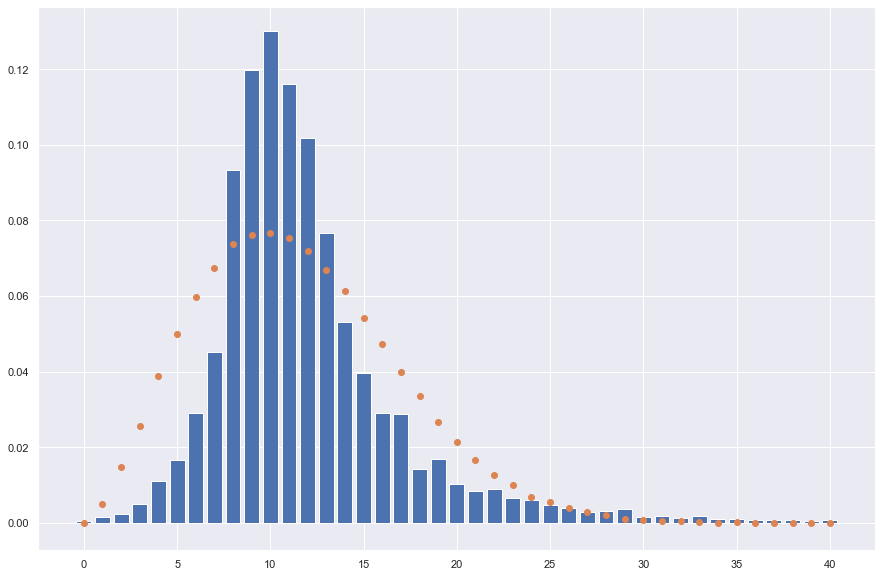

In [320]:
prediction= (c*lmbda)*(y*lmbda)**(c-1)*np.exp(-(y*lmbda)**c)
prediction.rename('Score',inplace=True)
df=pd.concat([y,prediction],axis=1)
x=df.groupby('Yards').mean()['Score']
Tally=NNFL.groupby(["Yards"]).count()
plt.bar(Tally.index.values,Tally.iloc[:,0].values/len(NNFL),zorder=1)
plt.scatter(x.index,x.values,zorder=2,alpha=1)
plt.show()

## Neural-Networks

In [323]:
batch_size=64

In [324]:
# https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        learning_rate: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        learning_rate = kwargs.pop('lr', learning_rate)
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = K.maximum(self.total_steps - warmup_steps, 1)
            decay_rate = (self.min_lr - lr) / decay_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr + decay_rate * K.minimum(t - warmup_steps, decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t))
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t))

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / (v_corr_t + self.epsilon), m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, learning_rate):
        self.learning_rate = learning_rate

    def get_config(self):
        config = {
            'learning_rate': float(K.get_value(self.learning_rate)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [325]:
def crps(y_true, y_pred):
    return K.mean(K.square(y_true - K.cumsum(y_pred, axis=1)), axis=1)

In [326]:
def get_model():
    x = keras.layers.Input(shape=[X_train.shape[1]])
    fc1 = keras.layers.Dense(units=450, input_shape=[X_train.shape[1]])(x)
    act1 = keras.layers.PReLU()(fc1)
    bn1 = keras.layers.BatchNormalization()(act1)
    dp1 = keras.layers.Dropout(0.5)(bn1)
    gn1 = keras.layers.GaussianNoise(0.15)(dp1)
    concat1 = keras.layers.Concatenate()([x, gn1])
    fc2 = keras.layers.Dense(units=600)(concat1)
    act2 = keras.layers.PReLU()(fc2)
    bn2 = keras.layers.BatchNormalization()(act2)
    dp2 = keras.layers.Dropout(0.5)(bn2)
    gn2 = keras.layers.GaussianNoise(0.15)(dp2)
    concat2 = keras.layers.Concatenate()([concat1, gn2])
    fc3 = keras.layers.Dense(units=400)(concat2)
    act3 = keras.layers.PReLU()(fc3)
    bn3 = keras.layers.BatchNormalization()(act3)
    dp3 = keras.layers.Dropout(0.5)(bn3)
    gn3 = keras.layers.GaussianNoise(0.15)(dp3)
    concat3 = keras.layers.Concatenate([concat2, gn3])
    output = keras.layers.Dense(units=199, activation='softmax')(concat2)
    model = keras.models.Model(inputs=[x], outputs=[output])
    return model


def train_model(X_train, y_train, X_val, y_val):
    model = get_model()
    model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-7), loss=crps)
    er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    model.fit(X_train, y_train, epochs=200, callbacks=[er], validation_data=[X_val, y_val], batch_size=batch_size)
    return model

### NOTE: THE CODE BELOW MAY COST YOU HOURs TO RUN

In [335]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=5)

models = []

for tr_idx, vl_idx in rkf.split(X_train, y_train):
    
    x_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    x_vl, y_vl = X_train[vl_idx], y_train[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

Train on 18450 samples, validate on 4613 samples
Epoch 1/200
18450/18450 [==============================] - 4s 243us/step - loss: 38.8008 - val_loss: 33.3286
Epoch 2/200
18450/18450 [==============================] - 4s 198us/step - loss: 38.8959 - val_loss: 33.3286
Epoch 3/200
18450/18450 [==============================] - 4s 197us/step - loss: 38.9391 - val_loss: 33.3286
Epoch 4/200
18450/18450 [==============================] - 4s 202us/step - loss: 38.8768 - val_loss: 35.8134
Epoch 5/200
18450/18450 [==============================] - 4s 207us/step - loss: 38.8926 - val_loss: 35.8170
Epoch 6/200
18450/18450 [==============================] - 4s 213us/step - loss: 38.8009 - val_loss: 35.8034
Epoch 7/200
18450/18450 [==============================] - 4s 203us/step - loss: 38.9445 - val_loss: 35.2402
Epoch 8/200
18450/18450 [==============================] - 4s 209us/step - loss: 38.8806 - val_loss: 33.3286
Epoch 9/200
18450/18450 [==============================] - 4s 235us/step - loss

18451/18451 [==============================] - 4s 191us/step - loss: 38.5609 - val_loss: 41.5946
Epoch 47/200
18451/18451 [==============================] - 4s 196us/step - loss: 38.6080 - val_loss: 41.9884
Train on 18451 samples, validate on 4612 samples
Epoch 1/200
18451/18451 [==============================] - 4s 229us/step - loss: 39.1090 - val_loss: 40.6965
Epoch 2/200
18451/18451 [==============================] - 4s 195us/step - loss: 38.9767 - val_loss: 39.5956
Epoch 3/200
18451/18451 [==============================] - 4s 197us/step - loss: 38.9564 - val_loss: 38.5828
Epoch 4/200
18451/18451 [==============================] - 4s 197us/step - loss: 38.9823 - val_loss: 39.9578
Epoch 5/200
18451/18451 [==============================] - 4s 193us/step - loss: 38.9562 - val_loss: 40.6952
Epoch 6/200
18451/18451 [==============================] - 4s 191us/step - loss: 38.8697 - val_loss: 37.6643
Epoch 7/200
18451/18451 [==============================] - 4s 192us/step - loss: 38.9571 -

18450/18450 [==============================] - 4s 192us/step - loss: 39.6523 - val_loss: 40.8612
Train on 18451 samples, validate on 4612 samples
Epoch 1/200
18451/18451 [==============================] - 4s 236us/step - loss: 39.0051 - val_loss: 34.7765
Epoch 2/200
18451/18451 [==============================] - 4s 196us/step - loss: 39.0757 - val_loss: 35.6313
Epoch 3/200
18451/18451 [==============================] - 4s 195us/step - loss: 38.9335 - val_loss: 37.0938
Epoch 4/200
18451/18451 [==============================] - 4s 197us/step - loss: 39.0610 - val_loss: 37.4738
Epoch 5/200
18451/18451 [==============================] - 4s 195us/step - loss: 39.1098 - val_loss: 35.0193
Epoch 6/200
18451/18451 [==============================] - 4s 194us/step - loss: 38.9929 - val_loss: 37.4944
Epoch 7/200
18451/18451 [==============================] - 4s 196us/step - loss: 39.1188 - val_loss: 37.5013
Epoch 8/200
18451/18451 [==============================] - 4s 194us/step - loss: 39.0185 - 

18451/18451 [==============================] - 4s 197us/step - loss: 38.0700 - val_loss: 36.3527
Epoch 12/200
18451/18451 [==============================] - 4s 195us/step - loss: 38.0080 - val_loss: 36.2754
Epoch 13/200
18451/18451 [==============================] - 4s 195us/step - loss: 38.0047 - val_loss: 36.3516
Epoch 14/200
18451/18451 [==============================] - 4s 196us/step - loss: 38.0202 - val_loss: 36.3501
Epoch 15/200
18451/18451 [==============================] - 4s 197us/step - loss: 38.0117 - val_loss: 36.3458
Epoch 16/200
18451/18451 [==============================] - 4s 199us/step - loss: 38.0455 - val_loss: 36.3520
Epoch 17/200
18451/18451 [==============================] - 4s 194us/step - loss: 38.0337 - val_loss: 36.1931
Epoch 18/200
18451/18451 [==============================] - 4s 205us/step - loss: 38.0433 - val_loss: 37.0648
Epoch 19/200
18451/18451 [==============================] - 4s 198us/step - loss: 38.0788 - val_loss: 34.8740
Epoch 20/200
18451/1845

Epoch 24/200
18450/18450 [==============================] - 4s 201us/step - loss: 36.5506 - val_loss: 38.7025
Epoch 25/200
18450/18450 [==============================] - 4s 199us/step - loss: 36.5506 - val_loss: 38.9697
Epoch 26/200
18450/18450 [==============================] - 4s 199us/step - loss: 36.6147 - val_loss: 38.6694
Epoch 27/200
18450/18450 [==============================] - 4s 198us/step - loss: 36.5976 - val_loss: 38.9002
Epoch 28/200
18450/18450 [==============================] - 4s 200us/step - loss: 36.5935 - val_loss: 38.9183
Epoch 29/200
18450/18450 [==============================] - 4s 198us/step - loss: 36.5519 - val_loss: 38.9434
Epoch 30/200
18450/18450 [==============================] - 4s 201us/step - loss: 36.5285 - val_loss: 39.6152
Epoch 31/200
18450/18450 [==============================] - 4s 199us/step - loss: 36.5757 - val_loss: 38.9311
Epoch 32/200
18450/18450 [==============================] - 4s 200us/step - loss: 36.5623 - val_loss: 38.6113
Epoch 33/2

Epoch 29/200
18451/18451 [==============================] - 4s 214us/step - loss: 39.6975 - val_loss: 41.6391
Epoch 30/200
18451/18451 [==============================] - 5s 246us/step - loss: 39.7136 - val_loss: 41.9825
Epoch 31/200
18451/18451 [==============================] - 5s 254us/step - loss: 39.7469 - val_loss: 41.9827
Epoch 32/200
18451/18451 [==============================] - 4s 207us/step - loss: 39.7785 - val_loss: 38.4804
Epoch 33/200
18451/18451 [==============================] - 4s 215us/step - loss: 39.8450 - val_loss: 39.2591
Epoch 34/200
18451/18451 [==============================] - 4s 204us/step - loss: 39.7277 - val_loss: 41.9302
Epoch 35/200
18451/18451 [==============================] - 4s 212us/step - loss: 39.6733 - val_loss: 38.7263
Epoch 36/200
18451/18451 [==============================] - 4s 206us/step - loss: 39.7604 - val_loss: 41.8392
Epoch 37/200
18451/18451 [==============================] - 4s 206us/step - loss: 39.6102 - val_loss: 40.0546
Train on 1

18451/18451 [==============================] - 4s 227us/step - loss: 36.7195 - val_loss: 41.0750
Epoch 17/200
18451/18451 [==============================] - 4s 215us/step - loss: 36.7019 - val_loss: 40.0394
Epoch 18/200
18451/18451 [==============================] - 4s 206us/step - loss: 36.7178 - val_loss: 41.7768
Epoch 19/200
18451/18451 [==============================] - 4s 212us/step - loss: 36.7215 - val_loss: 41.7812
Epoch 20/200
18451/18451 [==============================] - 4s 207us/step - loss: 36.6669 - val_loss: 41.7926
Epoch 21/200
18451/18451 [==============================] - 4s 207us/step - loss: 36.6863 - val_loss: 42.6306
Epoch 22/200
18451/18451 [==============================] - 4s 208us/step - loss: 36.6573 - val_loss: 41.0664
Epoch 23/200
18451/18451 [==============================] - 4s 208us/step - loss: 36.7661 - val_loss: 41.1711
Epoch 24/200
18451/18451 [==============================] - 4s 207us/step - loss: 36.7023 - val_loss: 39.8186
Epoch 25/200
18451/1845

In [336]:
def make_pred(df, sample, env, models):
    df['StadiumType'] = df['StadiumType'].apply(clean_StadiumType)
    df['StadiumType'] = df['StadiumType'].apply(transform_StadiumType)
    df['DefendersInTheBox_vs_Distance'] = df['DefendersInTheBox'] / df['Distance']
    df['OffenseFormation'] = df['OffenseFormation'].apply(lambda x: x if x in off_form else np.nan)
    df = pd.concat([df.drop(['OffenseFormation'], axis=1), pd.get_dummies(df['OffenseFormation'], prefix='Formation')], axis=1)
    missing_cols = set( dummy_col ) - set( df.columns )-set('Yards')
    for c in missing_cols:
        df[c] = 0
    df = df[dummy_col]
    df.drop(['Yards'], axis=1, inplace=True)
    df['Turf'] = df['Turf'].map(Turf)
    df['Turf'] = df['Turf'] == 'Natural'
    df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)
    df['HomePossesion'] = df['PossessionTeam'] == df['HomeTeamAbbr']
    df['Field_eq_Possession'] = df['FieldPosition'] == df['PossessionTeam']
    df['HomeField'] = df['FieldPosition'] == df['HomeTeamAbbr']
    df['GameClock'] = df['GameClock'].apply(strtoseconds)
    df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    df['PlayerBMI'] = 703*(df['PlayerWeight']/(df['PlayerHeight'])**2)
    df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    seconds_in_year = 60*60*24*365.25
    df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(str_to_float)
    df['WindDirection'] = df['WindDirection'].apply(clean_WindDirection)
    df['WindDirection'] = df['WindDirection'].apply(transform_WindDirection)
    df['PlayDirection'] = df['PlayDirection'].apply(lambda x: x.strip() == 'right')
    df['Team'] = df['Team'].apply(lambda x: x.strip()=='home')
    indoor = "indoor"
    df['GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.lower().replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly').replace('clear and sunny', 'sunny and clear').replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(map_weather)
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    df['X'] = df.apply(lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)
    df['Orientation'] = df.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
    df['Dir'] = df.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)
    df['YardsLeft'] = df.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
    df['YardsLeft'] = df.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)
    df = df.sort_values(by=['PlayId', 'Team', 'IsRusher', 'JerseyNumber']).reset_index()
    df = df.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate', 'NflId', 'NflIdRusher', 'GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1)
    cat_features = []
    for col in df.columns:
        if df[col].dtype =='object':
            cat_features.append(col)

    df = df.drop(cat_features, axis=1)
    df.fillna(-999, inplace=True)
    X = np.array(df[players_col]).reshape(-1, len(players_col)*22)
    play_col = df.drop(players_col, axis=1).columns
    X_play_col = np.zeros(shape=(X.shape[0], len(play_col)))
    for i, col in enumerate(play_col):
        X_play_col[:, i] = df[col][::22]
    X = np.concatenate([X, X_play_col], axis=1)
    X = scaler.transform(X)
    y_pred = np.mean([np.cumsum(model.predict(X), axis=1) for model in models], axis=0)
    yardsleft = np.array(df['YardsLeft'][::22])
    
    for i in range(len(yardsleft)):
        y_pred[i, :yardsleft[i]-1] = 0
        y_pred[i, yardsleft[i]+100:] = 1
    env.predict(pd.DataFrame(data=y_pred.clip(0,1),columns=sample.columns))
    return y_pred

In [8]:
y_pred1 = np.mean([np.cumsum(model.predict(X_train), axis=1) for model in models], axis=0)
yardsleft = np.array(train['YardsLeft'][::22])
for i in range(len(yardsleft)):
    y_pred1[i, :yardsleft[i]-1] = 0
    y_pred1[i, yardsleft[i]+100:] = 1
y_pred1=y_pred1.clip(0,1)

In [356]:
yards_pred=pd.Series([np.sum(y_pred1[i,:]) for i in range(len(y_pred))])

In [361]:
yards_true=pd.Series([100-np.sum(y_train[i,:]) for i in range(len(y_train))])

In [358]:
yards_pred=(np.sum(y_pred1*np.arange(-99,100),axis=1))

In [360]:
yards_pred1=np.concatenate((np.diff(y_pred1),np.array([0]*len(y_pred1))[:,np.newaxis]),axis=1)

In [347]:
yards1=np.sum(y_p*np.arange(-99,100),axis=1)

In [345]:
y_p = np.mean([model.predict(X_train) for model in models], axis=0)

In [353]:
MFE = np.mean((yards1+4-yards_true)**2)
RMFE = np.mean((yards1+4-yards_true)**2)**0.5
MAE = np.mean(np.abs(yards1+3-yards_true))
print('MFE: ' + str(MFE) + '\nRMFE: ' + str(RMFE) + '\nMAE' + str(MAE))